In [12]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import sklearn
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

Load necessary datasets

In [13]:
#load mutations table for RNAP
mutations = pd.read_csv('data/RNAP_MUTATIONS.csv')
mutations


,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS
0,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
1,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,NaN
2,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
3,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,E561E,gag,gaa,NaN,NaN,561.0,True,NaN,NaN,561.0,E,1.0,False,NaN,NaN
4,site.01.subj.DR0134.lab.DR0134.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176550,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoB,1326_del_gttgaccca,NaN,NaN,1326.0,761132.0,1326.0,True,-9.0,gttgaccca,NaN,NaN,NaN,False,NaN,NaN
176551,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,A172V,gcc,gtc,NaN,NaN,172.0,True,NaN,NaN,172.0,V,1.0,False,NaN,NaN
176552,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,R173R,cgg,agg,NaN,NaN,173.0,True,NaN,NaN,173.0,R,1.0,False,NaN,NaN
176553,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,P601L,ccg,ctg,NaN,NaN,601.0,True,NaN,NaN,601.0,L,1.0,False,NaN,NaN


In [14]:
#load known resistance mutations from EFFECTS table
effects = pd.read_pickle('data/EFFECTS.pkl.gz')
effects.reset_index(inplace = True)
effects['GENE_MUTATION'] = effects['GENE'].astype(str) + '_' + effects['MUTATION']
effects = effects[(effects.DRUG=='RIF') & (effects.PREDICTION=='R') 
                  & (~effects.MUTATION.str[-1].isin(['O','X']))]

resistance_mutations = effects.GENE_MUTATION.unique()
len(resistance_mutations)

128

In [15]:
#load conservative list of CMs from previous paper
CMs = pd.read_csv('data/final_CM_hit_list.csv')
CMs = CMs[CMs.homoplasy == True]
CMs

compensatory_mutations = CMs['putative CM'].unique()
len(compensatory_mutations)

51

In [16]:
#add resistance and compensatory mutation flags to mutations table: need to check for minor allele before concatenating GENE_MUTATION 
# use resistance catalogue of WHO instead?
mutations['GENE_MUTATION'] = np.where(
    mutations['IS_MINOR_ALLELE'],  # Condition: if IS_MINOR_ALLELE is True
    mutations['GENE'].astype(str) + '_' + mutations['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations['GENE'].astype(str) + '_' + mutations['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)
    
mutations['RESISTANT_MUTATION'] = mutations['GENE_MUTATION'].isin(resistance_mutations)
mutations['COMPENSATORY_MUTATION'] = mutations['GENE_MUTATION'].isin(compensatory_mutations)

mutations

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION
0,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
1,site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,NaN,rpoB_A1075A,False,False
2,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
3,site.01.subj.DR0674.lab.DR0674.iso.1,rpoB,E561E,gag,gaa,NaN,NaN,561.0,True,NaN,NaN,561.0,E,1.0,False,NaN,NaN,rpoB_E561E,False,False
4,site.01.subj.DR0134.lab.DR0134.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,NaN,rpoB_S450L,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176550,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoB,1326_del_gttgaccca,NaN,NaN,1326.0,761132.0,1326.0,True,-9.0,gttgaccca,NaN,NaN,NaN,False,NaN,NaN,rpoB_1326_del_gttgaccca,True,False
176551,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,A172V,gcc,gtc,NaN,NaN,172.0,True,NaN,NaN,172.0,V,1.0,False,NaN,NaN,rpoC_A172V,False,False
176552,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,R173R,cgg,agg,NaN,NaN,173.0,True,NaN,NaN,173.0,R,1.0,False,NaN,NaN,rpoC_R173R,False,False
176553,site.07.subj.718655D6-1333-4F67-AABF-09C7E521D...,rpoC,P601L,ccg,ctg,NaN,NaN,601.0,True,NaN,NaN,601.0,L,1.0,False,NaN,NaN,rpoC_P601L,False,False


In [17]:
#add phenotypes flag to mutations table (filter out low quality phenotypes)
phenotypes = pd.read_pickle('data/DST_MEASUREMENTS.pkl.gz')
phenotypes.reset_index(inplace = True)
phenotypes = phenotypes[(phenotypes.DRUG == 'RIF')] #  & (phenotypes.QUALITY != 'LOW')
phenotypes

#merge mutations and phenotypes tables, can also do a left join to keep samples without phenotypes (might be useful for CM statistics)
mutations_phenotypes = pd.merge(mutations, phenotypes[['UNIQUEID','PHENOTYPE','QUALITY']], on = 'UNIQUEID', how = 'inner')
mutations_phenotypes['PHENOTYPE'] = mutations_phenotypes['PHENOTYPE'] == 'R'

#drop UNIQUEIDs with phenotypes of low quality
low_quality_ids = mutations_phenotypes[mutations_phenotypes['QUALITY'] == 'LOW']['UNIQUEID'].unique()
mutations_phenotypes = mutations_phenotypes[~mutations_phenotypes['UNIQUEID'].isin(low_quality_ids)]

mutations_phenotypes = mutations_phenotypes.drop(columns = ['QUALITY'])
print(len(mutations_phenotypes.UNIQUEID.unique()))

28052


Calculate sensitivity and specificity of RIF resistance in all samples using different FRS scores

In [18]:
# aggregate mutations_phenotype by UNIQUEID and keep columns of interest: included new definition of FRS
def aggregate_minor_major_allele(group):
    # Check if any row has both IS_MINOR_ALLELE == True and RESISTANT_MUTATION == True
    minor_allele_flag = any((group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True))
    major_allele_flag = any((group['IS_MINOR_ALLELE'] == False) & (group['RESISTANT_MUTATION'] == True))

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True)]
    
    if not resistant_minor_allele_rows.empty:
        # If there are resistant minor alleles, get the maximum FRS value for those rows
        frs_value = resistant_minor_allele_rows['FRS'].max()
    else:
        # Otherwise, use the maximum FRS value from the entire group
        frs_value = group['FRS'].max()
    
    return pd.Series({
        'RESISTANT_MUTATION': group['RESISTANT_MUTATION'].max(),
        'COMPENSATORY_MUTATION': group['COMPENSATORY_MUTATION'].max(),
        'PHENOTYPE': group['PHENOTYPE'].max(),
        'R_MINOR_ALLELE': minor_allele_flag,
        'R_MAJOR_ALLELE': major_allele_flag,
        'FRS': frs_value,  # Use the maximum FRS for resistant minor alleles, if present
    })

# Apply the custom aggregation function
mutations_agg_phen = mutations_phenotypes.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_1674/1777167371.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mutations_agg_phen = mutations_phenotypes.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()


In [19]:
# define function for calculating sensitivity, specificity, PPV and NPV
#calculate sensitivity: number of phenotypically resistant samples that are found to have a resistant mutation / total number of phenotypically resistant samples
#calculate specificity: number of phenotypically sensitive samples that do not have a resistance mutation / total number of phenotypically sensitive samples
#calculate PPV: number of samples with a resistance mutation that are phenotypically resistant / total number of samples with a resistance mutation
#calculate NPV: number of samples without a resistance mutation that are phenotypically sensitive / total number of samples without a resistance mutation

def calculate_statistics(df):
    sensitivity = df[(df['PHENOTYPE'] == True) & (df['RESISTANT_MUTATION'] == True)].shape[0] / df[df['PHENOTYPE'] == True].shape[0]
    specificity = df[(df['PHENOTYPE'] == False) & (df['RESISTANT_MUTATION'] == False)].shape[0] / df[df['PHENOTYPE'] == False].shape[0]
    PPV = df[(df['RESISTANT_MUTATION'] == True) & (df['PHENOTYPE'] == True)].shape[0] / df[df['RESISTANT_MUTATION'] == True].shape[0]
    NPV = df[(df['RESISTANT_MUTATION'] == False) & (df['PHENOTYPE'] == False)].shape[0] / df[df['RESISTANT_MUTATION'] == False].shape[0]
    return sensitivity, specificity, PPV, NPV

In [20]:
#calculate statistics for no FRS cutoff
print(mutations_agg_phen.RESISTANT_MUTATION.value_counts())
sen_all, spe_all, ppv_all, npv_all = calculate_statistics(mutations_agg_phen)
sen_all, spe_all, ppv_all, npv_all

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

In [21]:
#calculate statistics for FRS cutoff >=0.9 (major allele definition)
major_mutations = mutations_agg_phen.copy()
major_mutations['RESISTANT_MUTATION'] = major_mutations['R_MAJOR_ALLELE']
print(major_mutations.RESISTANT_MUTATION.value_counts())
sen_maj, spe_maj, ppv_maj, npv_maj = calculate_statistics(major_mutations)
sen_maj, spe_maj, ppv_maj, npv_maj

RESISTANT_MUTATION
False    17566
True     10486
Name: count, dtype: int64


(0.9501878793718085, 0.964691902902733, 0.940492084684341, 0.9705681430035296)

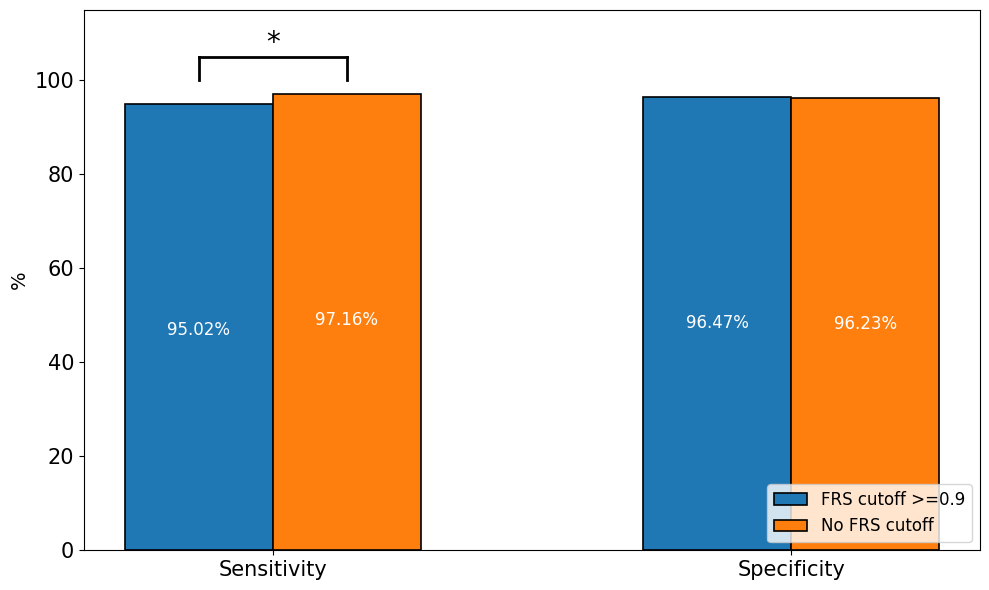

In [22]:
# plot sensitivity and specificity for no FRS cutoff and for FRS cutoff >=0.9 (major allele definition) as a histogram
def create_stats_df(sen_1, sen_2, spe_1, spe_2):
    stats = pd.DataFrame({
        'Metric': ['Sensitivity', 'Specificity'],
        'FRS cutoff >=0.9 (major allele definition)': [sen_1, spe_1],
        'No FRS cutoff': [sen_2, spe_2]
    })
    return stats


def plot_stats_histogram(stats, significant = True, save_figure=False, save_name='sensitivity_specificity_histogram', legend_label_1 = 'FRS cutoff >=0.9', legen_label_2 = 'No FRS cutoff'):
    # Adjusting the plot to group bars by criteria and display percentage inside the bar
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plotting bars next to each other
    x = [0, 0.7]  # positions for FRS cutoff >=0.9 (major allele definition)
    bar_width = 0.2

    bars1 = ax.bar(x, stats['FRS cutoff >=0.9 (major allele definition)'], 
                width=bar_width, color='#1f77b4', edgecolor='black', linewidth=1.2, label=legend_label_1)
    bars2 = ax.bar([p + bar_width for p in x], stats['No FRS cutoff'], 
                width=bar_width, color='#ff7f0e', edgecolor='black', linewidth=1.2, label=legen_label_2)

    # Adding percentage values inside the bars
    for bars in [bars1, bars2]:
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, yval - 0.5, f'{yval:.2%}', 
                    ha='center', va='bottom', fontsize=12, color='white')

    # Customize the plot
    # Set y-axis to display values as percentages without the percent sign
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

    # ax.set_title('Sensitivity and Specificity for Rifampicin Resistance', fontsize=18)
    ax.set_ylabel('%', fontsize=14)
    ax.set_ylim(0, 1.15)

    # Setting custom x-axis labels
    ax.set_xticks([r + bar_width/2 for r in x])
    ax.set_xticklabels(['Sensitivity', 'Specificity'], fontsize=15)

    # Increase axis fontsizes
    ax.tick_params(axis='both', which='major', labelsize=15)

    # Adding the legend
    ax.legend(loc='lower right', fontsize=12)

    #add significance indicator with horizontal bar between bars of sensitivity
    if significant:
        ax.plot([0, 0], [1, 1.05], color='black', lw=2)
        ax.plot([0.2, 0.2], [1, 1.05], color='black', lw=2)
        ax.plot([0, 0.2], [1.05, 1.05], color='black', lw=2)
        ax.text(0.1, 1.08, '*', fontsize=20, color='black', ha='center', va='center')

    plt.tight_layout()
    plt.show()

    #save figure if print_stats is True
    if save_figure:
        fig.savefig(f'figures/{save_name}.png', dpi=300)


stats = create_stats_df(sen_maj, sen_all, spe_maj, spe_all)
plot_stats_histogram(stats, significant = True, save_figure=True, save_name = 'sensitivity_specificity_histogram')

In [23]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == True) & (mutations_agg_phen['RESISTANT_MUTATION'] == True)].shape[0], major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == True].shape[0], major_mutations[major_mutations['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == False) & (mutations_agg_phen['RESISTANT_MUTATION'] == False)].shape[0], major_mutations[(major_mutations['PHENOTYPE'] == False) & (major_mutations['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == False].shape[0], major_mutations[major_mutations['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)


[10084  9862] [10379 10379] 7.947669635398789 1.9005266452625613e-15
[17007 17049] [17673 17673] -1.1913181357783043 0.23352871690872834


In [24]:
#calculate statistics for FRS cutoff >=0.5 
minor_cutoff = mutations_agg_phen.copy()
minor_cutoff['RESISTANT_MUTATION'] = ((minor_cutoff['FRS'] >= 0.0) & (minor_cutoff['R_MINOR_ALLELE'] == True)) | (minor_cutoff['R_MAJOR_ALLELE'] == True)
print(minor_cutoff.RESISTANT_MUTATION.value_counts())
calculate_statistics(minor_cutoff)

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

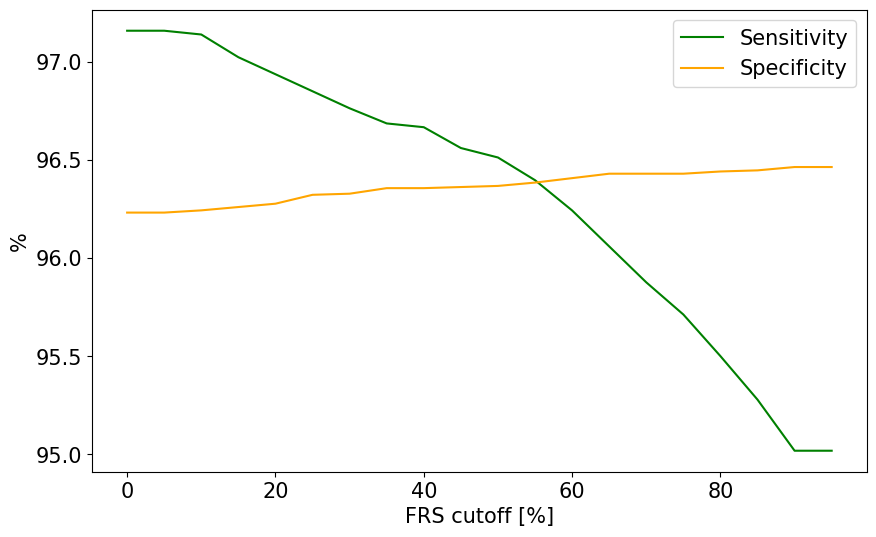

In [25]:
#plot the sensitivity for different FRS cutoffs
sensitivity = []
specificity = []
PPV = []
NPV = []
FRS = []

for i in range(0, 100, 5):
    cutoff = i/100
    df = mutations_agg_phen.copy()

    # assign RESISTANT_MUTATION column to True if FRS is >= cutoff while R_MINOR_ALLELE is True or if R_MAJOR_ALLELE is True
    df['RESISTANT_MUTATION'] = ((df['FRS'] >= cutoff) & (df['R_MINOR_ALLELE'] == True)) | (df['R_MAJOR_ALLELE'] == True)

    # df = df[(df.FRS.isna())|(df.FRS>=cutoff)]

    # calculate_statistics(df)
    sensitivity.append(df[(df['PHENOTYPE'] == True) & (df['RESISTANT_MUTATION'] == True)].shape[0] / df[df['PHENOTYPE'] == True].shape[0])
    specificity.append(df[(df['PHENOTYPE'] == False) & (df['RESISTANT_MUTATION'] == False)].shape[0] / df[df['PHENOTYPE'] == False].shape[0])
    # PPV.append(df[(df['RESISTANT_MUTATION'] == True) & (df['PHENOTYPE'] == True)].shape[0] / df[df['RESISTANT_MUTATION'] == True].shape[0])
    # NPV.append(df[(df['RESISTANT_MUTATION'] == False) & (df['PHENOTYPE'] == False)].shape[0] / df[df['RESISTANT_MUTATION'] == False].shape[0])
    FRS.append(cutoff)


fig, ax1 = plt.subplots(figsize=(10, 6))

#plot sensitivity and specificity using one y axis
plt.plot(FRS, sensitivity, label = 'Sensitivity', color = 'green')
plt.plot(FRS, specificity, label = 'Specificity', color = 'orange') 
plt.legend(fontsize=15)
plt.xlabel('FRS cutoff [%]', fontsize=15)
plt.ylabel('%', fontsize=15)
# plt.title('Sensitivity and Specificity for different FRS cutoffs')

#increase tick label sizes
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.1f}'.format(y * 100)))
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x * 100)))

# #save figure in high resolution
plt.savefig('figures/sensitivity_specificity_FRS_cutoff.png', dpi=300)

plt.show()

Check how much presence of CMs can improve predictions (with and without considering minor alleles)

In [26]:
#calculate statistics for CMs indicating resistance, excluding minor alleles
CM_mutations = mutations_agg_phen.copy()
CM_mutations['RESISTANT_MUTATION'] = (CM_mutations['COMPENSATORY_MUTATION'] == True) | (CM_mutations['R_MAJOR_ALLELE'] == True)
print(CM_mutations.RESISTANT_MUTATION.value_counts())
print(CM_mutations[(CM_mutations['PHENOTYPE'] == True) & (CM_mutations['RESISTANT_MUTATION'] == True)].shape[0])
print(CM_mutations[(CM_mutations['PHENOTYPE'] == True) & (CM_mutations['RESISTANT_MUTATION'] == False)].shape[0])
sen_CM_maj, spe_CM_maj, ppv_CM_maj, npv_CM_maj = calculate_statistics(CM_mutations)
sen_CM_maj, spe_CM_maj, ppv_CM_maj, npv_CM_maj

RESISTANT_MUTATION
False    17540
True     10512
Name: count, dtype: int64
9884
495


(0.9523075440793911,
 0.9644655689469813,
 0.9402587519025876,
 0.9717787913340935)

In [27]:
#calculate statistics for FRS cutoff >=0.9 (major allele definition) without considering CMs
major_mutations = mutations_agg_phen.copy()
major_mutations['RESISTANT_MUTATION'] = major_mutations['R_MAJOR_ALLELE']
print(major_mutations.RESISTANT_MUTATION.value_counts())
print(major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == True)].shape[0])
print(major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == False)].shape[0])
sen_maj, spe_maj, ppv_maj, npv_maj = calculate_statistics(major_mutations)
sen_maj, spe_maj, ppv_maj, npv_maj

RESISTANT_MUTATION
False    17566
True     10486
Name: count, dtype: int64
9862
517


(0.9501878793718085, 0.964691902902733, 0.940492084684341, 0.9705681430035296)

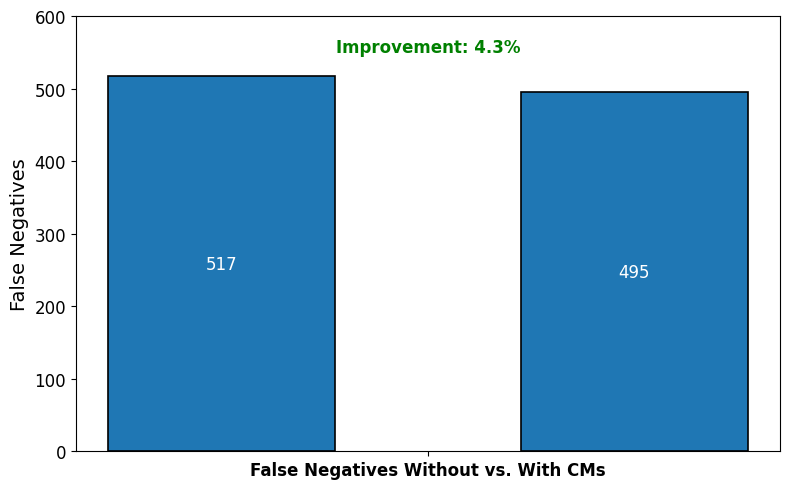

In [28]:
#make a nice plot for false negatives wihtout and with CMs. showing the improvement from 517 FNs to 495 FNs in percentage
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd

# Data setup
FNs = pd.DataFrame({
    'FNs': [517, 495],  # Updated counts for Without CMs and With CMs
    'Type': ['Without CMs', 'With CMs']
})

# Calculate improvement percentage
improvement_percentage = ((517 - 495) / 517) * 100

# Plot setup
fig, ax = plt.subplots(figsize=(8, 5))

# Plot bars close together
x = [0, 0.4]  # Adjusted positions for closer bars
bar_width = 0.22

bars = ax.bar(x, FNs['FNs'],
              width=bar_width, color='#1f77b4', edgecolor='black', linewidth=1.2)

# Adding values inside the bars
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{yval:.0f}',  # Position text in the middle
            ha='center', va='center', fontsize=12, color='white')

# Customize the plot
ax.set_ylabel('False Negatives', fontsize=14)
ax.set_ylim(0, 600)

# Setting x-axis to be centered
center_position = sum(x) / len(x)  # Calculate middle position
ax.set_xticks([center_position])
ax.set_xticklabels(["False Negatives Without vs. With CMs"], fontsize=14, weight='bold')

# Set y-axis to display integer values
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y)))

# Adding improvement percentage as an annotation
ax.annotate(f"Improvement: {improvement_percentage:.1f}%",
            xy=(0.2, 550), ha='center', fontsize=12, color='green', fontweight='bold')

# Increase tick label sizes
ax.tick_params(axis='both', which='major', labelsize=12)

plt.tight_layout()

#save figure in high resolution
plt.savefig('figures/FN_improvement_CMs.png', dpi=300)

plt.show()


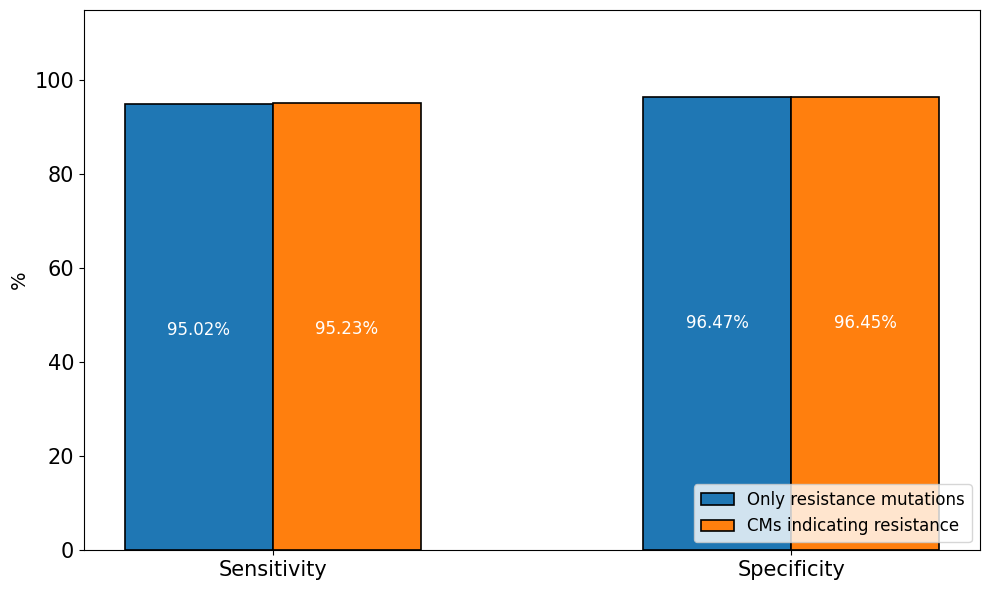

In [29]:
stats = create_stats_df(sen_maj, sen_CM_maj, spe_maj, spe_CM_maj)
plot_stats_histogram(stats, significant = False, save_figure=True, save_name = 'sensitivity_specificity_histogram_CM', legend_label_1='Only resistance mutations', legen_label_2='CMs indicating resistance')

In [30]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([major_mutations[(major_mutations['PHENOTYPE'] == True) & (major_mutations['RESISTANT_MUTATION'] == True)].shape[0], CM_mutations[(CM_mutations['PHENOTYPE'] == True) & (CM_mutations['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([major_mutations[major_mutations['PHENOTYPE'] == True].shape[0], CM_mutations[CM_mutations['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([major_mutations[(major_mutations['PHENOTYPE'] == False) & (major_mutations['RESISTANT_MUTATION'] == False)].shape[0], CM_mutations[(CM_mutations['PHENOTYPE'] == False) & (CM_mutations['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([major_mutations[major_mutations['PHENOTYPE'] == False].shape[0], CM_mutations[CM_mutations['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)


[9862 9884] [10379 10379] -0.709064286924491 0.4782845838113805
[17049 17045] [17673 17673] 0.1151036207073956 0.9083629900717725


In [31]:
#calculate statistics for CMs indicating resistance, including minor alleles
CM_mutations_minor = mutations_agg_phen.copy()
CM_mutations_minor['RESISTANT_MUTATION'] = (CM_mutations_minor['COMPENSATORY_MUTATION'] == True) | (CM_mutations_minor['RESISTANT_MUTATION'] == True)
print(CM_mutations_minor.RESISTANT_MUTATION.value_counts())
sen_CM_all, spe_CM_all, ppv_CM_all, npv_CM_all = calculate_statistics(CM_mutations_minor)
sen_CM_all, spe_CM_all, ppv_CM_all, npv_CM_all

RESISTANT_MUTATION
False    17288
True     10764
Name: count, dtype: int64


(0.9728297523846228, 0.9622588128784021, 0.938034188034188, 0.9836881073577047)

In [32]:
#calculate statistics for no FRS cutoff, without considering CMs
print(mutations_agg_phen.RESISTANT_MUTATION.value_counts())
sen_all, spe_all, ppv_all, npv_all = calculate_statistics(mutations_agg_phen)
sen_all, spe_all, ppv_all, npv_all

RESISTANT_MUTATION
False    17302
True     10750
Name: count, dtype: int64


(0.971577223239233, 0.96231539636734, 0.938046511627907, 0.9829499479828921)

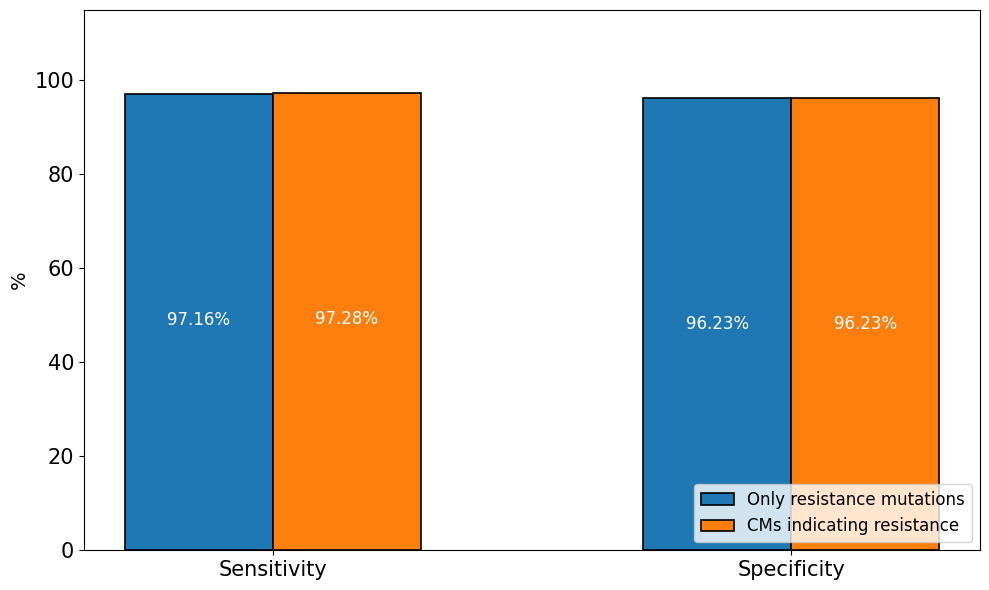

In [33]:
stats = create_stats_df(sen_all, sen_CM_all, spe_all, spe_CM_all)
plot_stats_histogram(stats, significant = False, save_figure=True, save_name = 'sensitivity_specificity_histogram_CM_minor', legend_label_1='Only resistance mutations', legen_label_2='CMs indicating resistance')

In [34]:
#perform a z test to test for significant difference between the sensitivities and specificities
from statsmodels.stats.proportion import proportions_ztest

# Sensitivity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == True) & (mutations_agg_phen['RESISTANT_MUTATION'] == True)].shape[0], CM_mutations_minor[(CM_mutations_minor['PHENOTYPE'] == True) & (CM_mutations_minor['RESISTANT_MUTATION'] == True)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == True].shape[0], CM_mutations_minor[CM_mutations_minor['PHENOTYPE'] == True].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

# Specificity
count = np.array([mutations_agg_phen[(mutations_agg_phen['PHENOTYPE'] == False) & (mutations_agg_phen['RESISTANT_MUTATION'] == False)].shape[0], CM_mutations_minor[(CM_mutations_minor['PHENOTYPE'] == False) & (CM_mutations_minor['RESISTANT_MUTATION'] == False)].shape[0]])
nobs = np.array([mutations_agg_phen[mutations_agg_phen['PHENOTYPE'] == False].shape[0], CM_mutations_minor[CM_mutations_minor['PHENOTYPE'] == False].shape[0]])
z, p = proportions_ztest(count, nobs)
print(count, nobs, z, p)

[10084 10097] [10379 10379] -0.5488793074361511 0.5830882796172004
[17007 17006] [17673 17673] 0.027921104387451576 0.9777250761371025


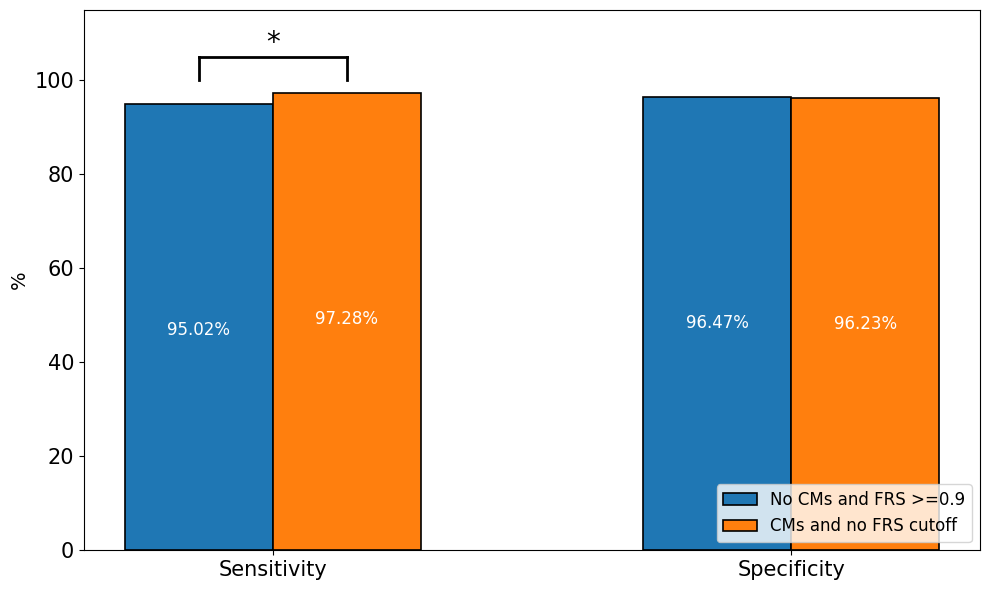

In [35]:
#Lastly, compare the sensitivity and specificity for FRS cutoff >=0.9 (major allele definition) without considering CMs with the sensitivity and specificity for CMs and minor alleles indicating resistance
stats = create_stats_df(sen_maj, sen_CM_all, spe_maj, spe_CM_all)
plot_stats_histogram(stats, significant = True, save_figure=True, save_name = 'sensitivity_specificity_histogram_all_vs_major', legend_label_1='No CMs and FRS >=0.9', legen_label_2='CMs and no FRS cutoff')

Check how CM presence differs in major and minor allele populations

In [36]:
# aggregate mutations_phenotype by UNIQUEID and keep columns of interest: double-check if definiion of FRS is correct
def aggregate_minor_major_allele(group):
    # Check if any row has both IS_MINOR_ALLELE == True and RESISTANT_MUTATION == True
    minor_allele_flag = any((group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True))
    major_allele_flag = any((group['IS_MINOR_ALLELE'] == False) & (group['RESISTANT_MUTATION'] == True))

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE'] == True) & (group['RESISTANT_MUTATION'] == True)]
    
    if not resistant_minor_allele_rows.empty:
        # If there are resistant minor alleles, get the maximum FRS value for those rows
        frs_value = resistant_minor_allele_rows['FRS'].max()
    else:
        # Otherwise, use the maximum FRS value from the entire group
        frs_value = group['FRS'].max()
    
    return pd.Series({
        'RESISTANT_MUTATION': group['RESISTANT_MUTATION'].max(),
        'COMPENSATORY_MUTATION': group['COMPENSATORY_MUTATION'].max(),
        'R_MINOR_ALLELE': minor_allele_flag,
        'R_MAJOR_ALLELE': major_allele_flag,
        'FRS': frs_value,  # Use the maximum FRS for resistant minor alleles, if present
    })

# Apply the custom aggregation function
mutations_agg = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_1674/2026146715.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mutations_agg = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()


In [37]:
mutations_agg
#save mutations_agg table
mutations_agg.to_csv('data/mutations_agg-UNIQUEID.csv', index = False)

In [38]:
#check overlap
overlap = mutations_agg[(mutations_agg['R_MAJOR_ALLELE'] == True) & (mutations_agg['R_MINOR_ALLELE'] == True)].UNIQUEID.to_list()
len(overlap)

30

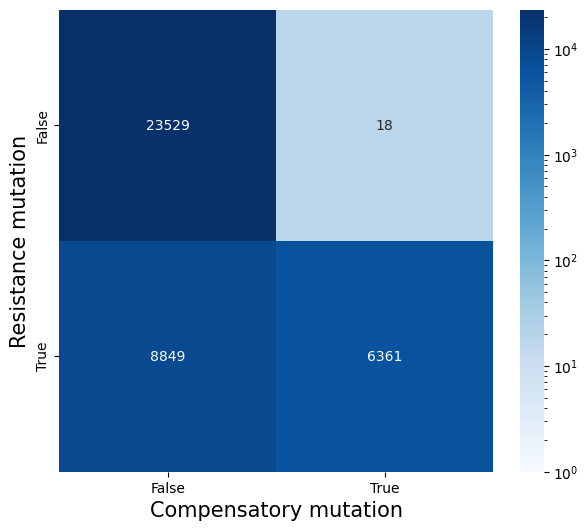

In [39]:
#make contingency matrix for samples based on resistance and compensatory mutations, exluding the overlap
from matplotlib.colors import LogNorm
def contingency_heatmap(df, overlap, save_name='contingency_heatmap.png'):
    contingency = pd.crosstab(df[~df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], df[~df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    contingency

    #show contingency matrix as heatmap in green colour, wihtout rounded values
    plt.figure(figsize=(7, 6))
    sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', 
                norm=LogNorm(vmin=1, vmax=contingency.max().max()), cbar=True)
    # plt.title('Contingency matrix for resistance and compensatory mutations')
    plt.xlabel('Compensatory mutation', fontsize=15)
    plt.ylabel('Resistance mutation', fontsize=15)

    #save figure in high resolution
    plt.savefig(f'figures/{save_name}', dpi=300)

    plt.show()

contingency_heatmap(mutations_agg, overlap, save_name='contingency_heatmap.png')

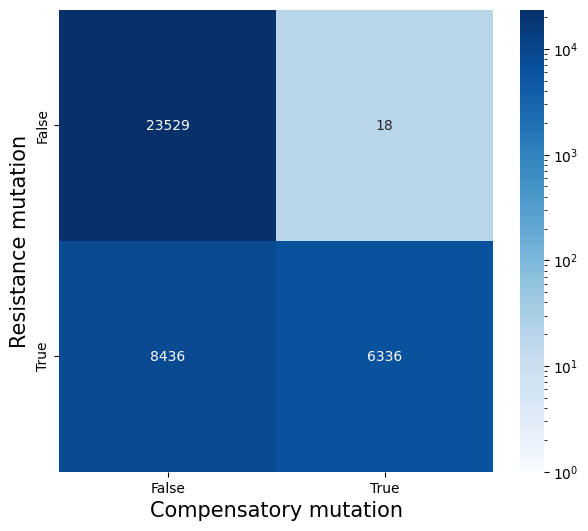

In [40]:
#exclude all samples with a minor allele from the analysis
mutations_agg_major = mutations_agg[~mutations_agg['R_MINOR_ALLELE']]
contingency_heatmap(mutations_agg_major, overlap, save_name='contingency_heatmap_major.png')


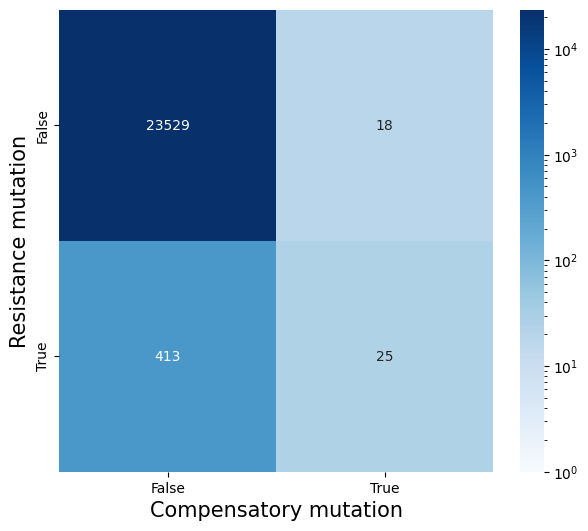

In [41]:
#exclude all samples with a resistant major allele from the analysis
mutations_agg_minor = mutations_agg[~mutations_agg['R_MAJOR_ALLELE']]
contingency_heatmap(mutations_agg_minor, overlap, save_name='contingency_heatmap_minor.png')

In [42]:
contingency_major = pd.crosstab(mutations_agg_major[~mutations_agg_major['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], mutations_agg_major[~mutations_agg_major['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]

contingency_minor = pd.crosstab(mutations_agg_minor[~mutations_agg_minor['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], mutations_agg_minor[~mutations_agg_minor['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_1674/244543749.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_1674/244543749.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


np.float64(0.05707762557077625)

/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_1674/2718738671.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  major_percentage = contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]
/var/folders/_3/8y_dwngx2614_y_52fzh1c4w0000gn/T/ipykernel_1674/2718738671.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  minor_percentage = contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]


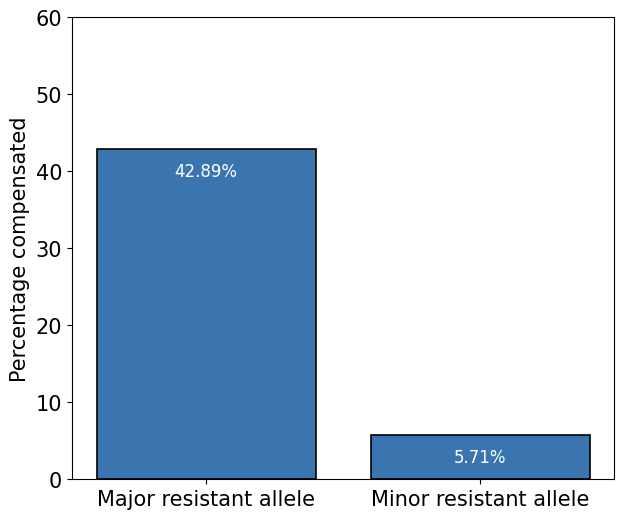

In [43]:
#make nice percentage plot of percentage of compensation in major vs minor resistant populations
#also plot the data as a bar plot of the lower row of the contingency matrix
def compensation_barplot(major_df, minor_df, save_name='contingency_barplot.png'):
    contingency_major = pd.crosstab(major_df[~major_df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], major_df[~major_df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    major_percentage = contingency_major.iloc[1,1]/contingency_major.sum(axis=1)[1]

    contingency_minor = pd.crosstab(minor_df[~minor_df['UNIQUEID'].isin(overlap)]['RESISTANT_MUTATION'], minor_df[~minor_df['UNIQUEID'].isin(overlap)]['COMPENSATORY_MUTATION'])
    minor_percentage = contingency_minor.iloc[1,1]/contingency_minor.sum(axis=1)[1]

    #plot the two percentages as a nice bar plot
    plt.figure(figsize=(7, 6))
    plt.bar(['Major resistant allele', 'Minor resistant allele'], [major_percentage, minor_percentage], color=['#3B75AF', '#3B75AF'], edgecolor='black', linewidth=1.2)
    plt.ylabel('Percentage compensated', fontsize=15)
    plt.ylim(0, 0.6)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

    #display percentages inside bars
    for i in range(2):
        plt.text(i, [major_percentage, minor_percentage][i] - 0.04, f'{[major_percentage, minor_percentage][i]:.2%}', ha='center', va='bottom', fontsize=12, color='white')

    # Set axes to display values as percentages without the percent sign
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

    #save figure in high resolution
    plt.savefig(f'figures/{save_name}', dpi=300)

    plt.show()

compensation_barplot(mutations_agg_major, mutations_agg_minor, save_name='contingency_barplot.png')

Check if the CMs found in resistant minor populations have an FRS similar or lower than the resistance mutation FRS

In [44]:
#Get the Uniqueids of samples with a resistant minor allele and a compensatory mutation and no resistant major mutations 
# - should be the lower right corner of the contingency table
res_minor_CM_uniqueids = mutations_agg[(~mutations_agg.R_MAJOR_ALLELE == True) 
                                       & (mutations_agg.COMPENSATORY_MUTATION == True) & (mutations_agg.R_MINOR_ALLELE == True)].UNIQUEID
len(res_minor_CM_uniqueids)

25

In [45]:
#get the Uniqueids of samples with a resistant minor allele and a MINOR compensatory mutation and no resistant major mutations
res_minor_CM_minor_uniqueids = mutations[mutations.UNIQUEID.isin(res_minor_CM_uniqueids) & (mutations.COMPENSATORY_MUTATION == True) & (mutations.IS_MINOR_ALLELE == True)].UNIQUEID
len(res_minor_CM_minor_uniqueids)

13

In [46]:
type(res_minor_CM_minor_uniqueids)

pandas.core.series.Series

In [47]:
#compare to number of minor compensatory mutations in whole dataset
mutations[(mutations.COMPENSATORY_MUTATION == True)].IS_MINOR_ALLELE.value_counts()

IS_MINOR_ALLELE
False    6347
True       44
Name: count, dtype: int64

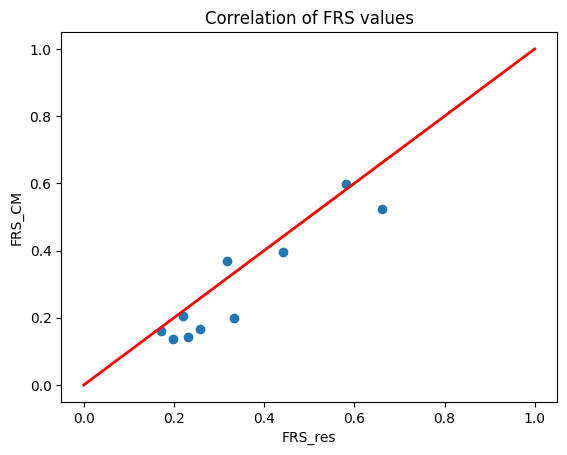

In [48]:
resistance = mutations[(mutations.RESISTANT_MUTATION == True) & (mutations.UNIQUEID.isin(res_minor_CM_minor_uniqueids))]
compensatory = mutations[mutations.UNIQUEID.isin(res_minor_CM_minor_uniqueids) & (mutations.COMPENSATORY_MUTATION == True)]

#join dfs resistance and compensation based on UNIQUEID
df_joined = pd.merge(resistance[['UNIQUEID','MINOR_MUTATION','FRS']], compensatory[['UNIQUEID','MINOR_MUTATION','FRS']], on = 'UNIQUEID', how = 'inner')
df_joined.rename(columns = {'FRS_x':'FRS_res','FRS_y':'FRS_CM','MINOR_MUTATION_x':'MINOR_MUTATION_res','MINOR_MUTATION_y':'MINOR_MUTATION_CM'}, inplace = True)
df_joined

#exclude UNIQUEIDs that appear more than once in the df
df_joined = df_joined[df_joined.duplicated(subset='UNIQUEID', keep=False) == False]
df_joined

#compare the FRX_x and FRS_y columns to see if the FRS values are roughly the same
df_joined['FRS_res'] = df_joined['FRS_res'].astype(float)
df_joined['FRS_CM'] = df_joined['FRS_CM'].astype(float)

df_joined['FRS_res'].corr(df_joined['FRS_CM'])

#plot the FRS values for the samples with a minor allele and a compensatory mutation
plt.scatter(df_joined['FRS_res'], df_joined['FRS_CM']) 
#add a line through (1,1) to (0,0) to indicate a perfect correlation
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_res')
plt.ylabel('FRS_CM')
plt.title('Correlation of FRS values')

plt.show()

In [49]:
#calculate correlation score
from scipy.stats import pearsonr
correlation, p_value = pearsonr(df_joined['FRS_res'], df_joined['FRS_CM'])
correlation, p_value

(np.float64(0.9306923205593568), np.float64(9.279352103495741e-05))

Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and only keep the higher FRS

Check if the samples with mixed populations have evolved resistance or acquired another infection - check how many other minor mutations detected in relevant samples

In [50]:
res_minor_uniqueids = mutations_agg[(mutations_agg['R_MINOR_ALLELE']) & (~mutations_agg['R_MAJOR_ALLELE'])].UNIQUEID
len(res_minor_uniqueids)

438

In [51]:
res_minor = mutations[mutations.UNIQUEID.isin(res_minor_uniqueids) & (mutations.RESISTANT_MUTATION == True) & (mutations.IS_MINOR_ALLELE == True)]
other_minor = mutations[mutations.UNIQUEID.isin(res_minor_uniqueids) & (mutations.RESISTANT_MUTATION == False) & (mutations.IS_MINOR_ALLELE == True)]

In [52]:
len(res_minor), len(other_minor)

(600, 6372)

In [53]:
df_joined = pd.merge(res_minor[['UNIQUEID','MINOR_MUTATION','FRS']], other_minor[['UNIQUEID','MINOR_MUTATION','FRS']], on = 'UNIQUEID', how = 'inner')
df_joined.rename(columns = {'FRS_x':'FRS_res','FRS_y':'FRS_other','MINOR_MUTATION_x':'MINOR_MUTATION_res','MINOR_MUTATION_other':'MINOR_MUTATION_CM'}, inplace = True)
df_joined

,UNIQUEID,MINOR_MUTATION_res,FRS_res,MINOR_MUTATION_y,FRS_other
0,site.01.subj.DR0182.lab.DR0182.iso.1,S450L,0.127,A1075A,0.165
1,site.16.subj.001.lab.10398.iso.1,D435G,0.819,A1075A,0.116
2,site.16.subj.001.lab.10398.iso.1,D435G,0.819,I1106T,0.888
3,site.16.subj.001.lab.10398.iso.1,L452P,0.828,A1075A,0.116
4,site.16.subj.001.lab.10398.iso.1,L452P,0.828,I1106T,0.888
...,...,...,...,...,...
8751,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,V994V,0.250
8752,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,V996V,0.240
8753,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,Y308Y,0.283
8754,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,1284_del_c,0.364,Y338Y,0.271


Check amount of minor alleles per resistant population sample... if high, probably an acquired infection (unrelated to original strain)

In [54]:
# export list of UNIQUEIDs from resistant minor allele samples, so we can run them through grumpy to get ALL minor mutations, not only in resistant genes...
res_minor_uniqueids

# export list of UNIQUEIDs from resistant minor allele samples, so we can run them through grumpy to get ALL minor mutations, not only in resistant genes...
res_minor_uniqueids.to_csv('data/res_minor_uniqueids.csv', index = False)

The below is from the 438 samples that contain at least one minor resistance allele, reprocessed using clockwork to get ALL minor alleles in the sample (not only the ones in resistance genes)

All these tables were generated using `gnomonicus` from the 438 samples which had a RIF RAV but at FRS < 90%.

Let's load in the `EFFECTS` table and take a look.

In [55]:
effects = pd.read_csv('reprocessed_data/effects.csv.gz')
effects = effects[(effects.drug=='RIF') & (effects.prediction=='R')]
effects[:3]

,uniqueid,gene,mutation,drug,prediction,catalogue_name,evidence,catalogue_version,prediction_values
69,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,S450L:75,RIF,R,WHO-UCN-GTB-PCI-2023.5,"{'Observed_samples': {'Present_SOLO_SR': 8912,...",2.0,RFUS
83,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,H445D:12,RIF,R,WHO-UCN-GTB-PCI-2023.5,"{'Observed_samples': {'Present_SOLO_SR': 574, ...",2.0,RFUS
101,site.00.subj.ES_FE23.lab.FE23.iso.1.v0.12.4.pe...,rpoB,H445Y:37,RIF,R,WHO-UCN-GTB-PCI-2023.5,"{'Observed_samples': {'Present_SOLO_SR': 484, ...",2.0,RFUS


Interestingly there are 121 samples that have two RIF RAVs, and 16 that have three! Obvious question (which may not be able to answer) is, for the ones with two, is this a mixture of two samples, each with an RAV, or are they both on the same genome?

In [56]:
summary_rif = effects[['uniqueid', 'mutation']].groupby('uniqueid').count()
summary_rif.mutation.value_counts()

mutation
1    291
2    121
3     16
Name: count, dtype: int64

Let's remember all the samples with one and only one RIF RAV as we can unambigously plot the number of *other* minor alleles each sample has for this subset

In [57]:
solo_rif = summary_rif[summary_rif.mutation==1]
len(solo_rif.index)

291

In [58]:
solo_rif_effects = effects[effects.uniqueid.isin(solo_rif.index)]
solo_rif_effects.set_index(['uniqueid','mutation'], inplace=True)
solo_rif_effects.index[:3]

MultiIndex([(                   'site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample', ...),
            (                         'site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample', ...),
            ('site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample', ...)],
           names=['uniqueid', 'mutation'])

We now need to find out what the FRS is for these samples. The problem is we need to join to the `VARIANTS` table but to do that we have to go via `MUTATIONS`.

In [59]:
mutations = pd.read_csv('reprocessed_data/mutations.csv.gz') 
mutations.set_index(['uniqueid','mutation'], inplace=True)
mutations[:3]

gene  ref  alt  \
uniqueid                                           mutation                  
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A     PE1  ggg  gcg   
                                                   G369R     PE1  ggc  cgc   
                                                   L485L     PE1  ctg  ttg   

                                                             nucleotide_number  \
uniqueid                                           mutation                      
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A                   NaN   
                                                   G369R                   NaN   
                                                   L485L                   NaN   

                                                             nucleotide_index  \
uniqueid                                           mutation                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A                  NaN   
                                                   G369R                  NaN   
                                                   L485L                  NaN   

                                                             gene_position  \
uniqueid                                           mutation                  
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A             286.0   
                                                   G369R             369.0   
                                                   L485L             485.0   

                                                             codes_protein  \
uniqueid                                           mutation                  
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A              True   
                                                   G369R              True   
                                                   L485L              True   

                                                             indel_length  \
uniqueid                                           mutation                 
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A              NaN   
                                                   G369R              NaN   
                                                   L485L              NaN   

                                                            indel_nucleotides  \
uniqueid                                           mutation                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A                  NaN   
                                                   G369R                  NaN   
                                                   L485L                  NaN   

                                                             amino_acid_number  \
uniqueid                                           mutation                      
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A                 286.0   
                                                   G369R                 369.0   
                                                   L485L                 485.0   

                                                            amino_acid_sequence  \
uniqueid                                           mutation                       
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A                      A   
                                                   G369R                      R   
                                                   L485L                      L   

                                                             number_nucleotide_changes  
uniqueid                                           mutation                             
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... G286A                           1.0  
                                                   G369R                           1.0  
                                                   L485L                           1.0

In [60]:
solo_rif_mutations = mutations[mutations.index.isin(solo_rif_effects.index)]
solo_rif_mutations.reset_index(inplace=True)
solo_rif_mutations.set_index(['uniqueid','gene','gene_position'], inplace=True)
solo_rif_mutations

,,,mutation,ref,alt,nucleotide_number,nucleotide_index,codes_protein,indel_length,indel_nucleotides,amino_acid_number,amino_acid_sequence,number_nucleotide_changes
uniqueid,gene,gene_position,,,,,,,,,,,
site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:75,tcg,ttg,NaN,NaN,True,NaN,NaN,450.0,L,1.0
site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample,rpoB,445.0,H445D:12,cac,gac,NaN,NaN,True,NaN,NaN,445.0,D,1.0
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample,rpoB,445.0,H445Y:12,cac,tac,NaN,NaN,True,NaN,NaN,445.0,Y,1.0
site.00.subj.NETHERLANDS_NLA009702465.lab.NLA009702465.iso.1.v0.12.4.per_sample,rpoB,445.0,H445D:11,cac,gac,NaN,NaN,True,NaN,NaN,445.0,D,1.0
site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:10,tcg,ttg,NaN,NaN,True,NaN,NaN,450.0,L,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per_sample,rpoB,450.0,S450L:82,tcg,ttg,NaN,NaN,True,NaN,NaN,450.0,L,1.0
site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per_sample,rpoB,435.0,D435Y:28,gac,tac,NaN,NaN,True,NaN,NaN,435.0,Y,1.0
site.28.subj.2133.lab.R28017.iso.1.v0.12.4.per_sample,rpoB,435.0,D435Y:5,gac,tac,NaN,NaN,True,NaN,NaN,435.0,Y,1.0


In [61]:
mutations.reset_index(inplace=True)
solo_mutations = mutations[mutations.uniqueid.isin(solo_rif.index)]
solo_mutations.set_index(['uniqueid','gene','gene_position'],inplace=True)

# don't forget to ignore the solo rif mutations themselves
solo_other_mutations = solo_mutations[~solo_mutations.index.isin(solo_rif_mutations.index)]
solo_other_mutations

mutation  \
uniqueid                                           gene   gene_position              
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0             L485L   
                                                   PE14    106.0             A106A   
                                                   PE16    96.0               A96A   
                                                   PE2     298.0             I298T   
                                                   PE23    282.0             S282R   
...                                                                            ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0            L31L:28   
                                                           33.0            A33A:27   
                                                   vapC47  46.0               S46L   
                                                   whiB6  -75.0          -75_del_g   
                                                   yrbE2A  111.0             A111A   

                                                                         ref  \
uniqueid                                           gene   gene_position        
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0         ctg   
                                                   PE14    106.0         gca   
                                                   PE16    96.0          gcg   
                                                   PE2     298.0         atc   
                                                   PE23    282.0         agt   
...                                                                      ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0          ctc   
                                                           33.0          gct   
                                                   vapC47  46.0          tcg   
                                                   whiB6  -75.0          NaN   
                                                   yrbE2A  111.0         gcc   

                                                                         alt  \
uniqueid                                           gene   gene_position        
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0         ttg   
                                                   PE14    106.0         gcc   
                                                   PE16    96.0          gct   
                                                   PE2     298.0         acc   
                                                   PE23    282.0         agg   
...                                                                      ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0          ctt   
                                                           33.0          gcc   
                                                   vapC47  46.0          ttg   
                                                   whiB6  -75.0          NaN   
                                                   yrbE2A  111.0         gcg   

                                                                         nucleotide_number  \
uniqueid                                           gene   gene_position                      
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE1     485.0                       NaN   
                                                   PE14    106.0                       NaN   
                                                   PE16    96.0                        NaN   
                                                   PE2     298.0                       NaN   
                                                   PE23    282.0                       NaN   
...                                                                                    ...   
site.35.subj.88.lab.IE12.iso.1.v0.12.4.per_sample  vapC31  31.0                        NaN   
                           

Now we can load in `VARIANTS` but that needs a bit of parsing before we can do anything.

In [62]:
variants = pd.read_pickle('reprocessed_data/variants.pkl.gz', compression='infer')
variants.reset_index(inplace=True)
variants[:3]

,uniqueid,variant,gene,gene_position,codon_idx,nucleotide_index,indel_length,indel_nucleotides,vcf_evidence,vcf_idx
0,site.00.subj.1190242.lab.H124040080.iso.1.v0.1...,1977a>g,dnaN,-75.0,NaN,1977,0,NaN,"{""DP"": 14, ""GT_CONF"": 97.1, ""COV"": [0, 14], ""A...",1.0
1,site.00.subj.1190242.lab.H124040080.iso.1.v0.1...,3446c>t,recF,56.0,1.0,3446,0,NaN,"{""COV"": [0, 24], ""COV_TOTAL"": 24, ""GT"": [1, 1]...",1.0
2,site.00.subj.1190242.lab.H124040080.iso.1.v0.1...,4013t>c,recF,245.0,1.0,4013,0,NaN,"{""COV"": [0, 16], ""ALLELE_DP"": [0, 16], ""COV_TO...",1.0


In [63]:
def find_minors(row):
    if ':' in row.variant:
        read_fraction = float(row.variant.split(':')[1])
        return pd.Series([True, read_fraction])
    else:
        return pd.Series([False,1])
    
variants[['is_minor', 'read_fraction']] = variants.apply(find_minors, axis=1)

def find_nulls(row):
    if row.variant[-1] in ['x','X']:
        return True
    else:
        return False

variants['is_null'] = variants.apply(find_nulls, axis=1)


def get_DP_FRS(row):
    a = (json.loads(row['vcf_evidence']))
    if a['DP'] is None:
        depth = None
    else:
        depth = int(a['DP'])
    if a['COV'] is None:
        coverage = None
    else:
        coverage = sum(a['COV'])

    if a['FRS'] == '.':
        frs = None
    else:
        frs = float(a['FRS'])
    
    return pd.Series([depth, frs, coverage])

variants[['DP', 'FRS', 'COV']] = variants.apply(get_DP_FRS, axis=1)

def find_true_frs(row):
    a = (json.loads(row['vcf_evidence']))
    allele = row.vcf_idx
    if allele>=0:
        rd = a['COV'][int(allele)] / sum(a['COV'])
    else:
        rd = None
    return rd

variants['true_frs'] = variants.apply(find_true_frs, axis=1)

variants.set_index(['uniqueid','gene','gene_position'],inplace=True)
variants[:3]

variant  \
uniqueid                                           gene gene_position            
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0          1977a>g   
                                                   recF  56.0          3446c>t   
                                                         245.0         4013t>c   

                                                                       codon_idx  \
uniqueid                                           gene gene_position              
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                NaN   
                                                   recF  56.0                1.0   
                                                         245.0               1.0   

                                                                       nucleotide_index  \
uniqueid                                           gene gene_position                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                      1977   
                                                   recF  56.0                      3446   
                                                         245.0                     4013   

                                                                       indel_length  \
uniqueid                                           gene gene_position                 
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                     0   
                                                   recF  56.0                     0   
                                                         245.0                    0   

                                                                      indel_nucleotides  \
uniqueid                                           gene gene_position                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                       NaN   
                                                   recF  56.0                       NaN   
                                                         245.0                      NaN   

                                                                                                            vcf_evidence  \
uniqueid                                           gene gene_position                                                      
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0          {"DP": 14, "GT_CONF": 97.1, "COV": [0, 14], "A...   
                                                   recF  56.0          {"COV": [0, 24], "COV_TOTAL": 24, "GT": [1, 1]...   
                                                         245.0         {"COV": [0, 16], "ALLELE_DP": [0, 16], "COV_TO...   

                                                                       vcf_idx  \
uniqueid                                           gene gene_position            
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0              1.0   
                                                   recF  56.0              1.0   
                                                         245.0             1.0   

                                                                       is_minor  \
uniqueid                                           gene gene_position             
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0             False   
                                                   recF  56.0             False   
                                                         245.0            False   

                                                                       read_fraction  \
uniqueid                                           gene gene_position                  
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                    1.0   
                                                   recF  56.0                    1.0   
                                                         245.0                   1.0   

  

In [64]:
variants[:3]

variant  \
uniqueid                                           gene gene_position            
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0          1977a>g   
                                                   recF  56.0          3446c>t   
                                                         245.0         4013t>c   

                                                                       codon_idx  \
uniqueid                                           gene gene_position              
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                NaN   
                                                   recF  56.0                1.0   
                                                         245.0               1.0   

                                                                       nucleotide_index  \
uniqueid                                           gene gene_position                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                      1977   
                                                   recF  56.0                      3446   
                                                         245.0                     4013   

                                                                       indel_length  \
uniqueid                                           gene gene_position                 
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                     0   
                                                   recF  56.0                     0   
                                                         245.0                    0   

                                                                      indel_nucleotides  \
uniqueid                                           gene gene_position                     
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                       NaN   
                                                   recF  56.0                       NaN   
                                                         245.0                      NaN   

                                                                                                            vcf_evidence  \
uniqueid                                           gene gene_position                                                      
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0          {"DP": 14, "GT_CONF": 97.1, "COV": [0, 14], "A...   
                                                   recF  56.0          {"COV": [0, 24], "COV_TOTAL": 24, "GT": [1, 1]...   
                                                         245.0         {"COV": [0, 16], "ALLELE_DP": [0, 16], "COV_TO...   

                                                                       vcf_idx  \
uniqueid                                           gene gene_position            
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0              1.0   
                                                   recF  56.0              1.0   
                                                         245.0             1.0   

                                                                       is_minor  \
uniqueid                                           gene gene_position             
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0             False   
                                                   recF  56.0             False   
                                                         245.0            False   

                                                                       read_fraction  \
uniqueid                                           gene gene_position                  
site.00.subj.1190242.lab.H124040080.iso.1.v0.12... dnaN -75.0                    1.0   
                                                   recF  56.0                    1.0   
                                                         245.0                   1.0   

  

There was a bug in `gnomonicus` which Jeremy fixed; here we explicitly calculate the `true_frs` such that the "mutant" is also the numerator (rather than 0/0 calls)

<Axes: xlabel='true_frs', ylabel='FRS'>

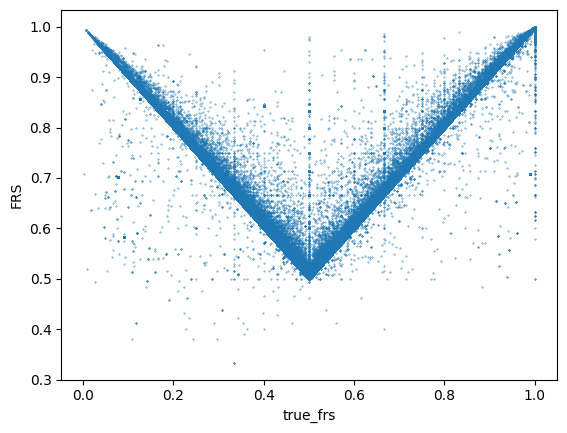

In [65]:
variants.plot.scatter(y='FRS', x='true_frs',s=.1)

In [66]:
len(solo_mutations), len(variants)

(1184144, 1721126)

Now we can join the table of solo RIF RAVs to `variants` to find out the FRS etc

In [67]:
solo_rif_variants = solo_rif_mutations[['mutation']].join(variants, how='inner')
solo_rif_variants.reset_index(inplace=True)
solo_rif_variants.set_index(['uniqueid'], inplace=True)
solo_rif_variants[:3]

,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,vcf_evidence,vcf_idx,is_minor,read_fraction,is_null,DP,FRS,COV,true_frs
uniqueid,,,,,,,,,,,,,,,,,
site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,"{""ALLELE_DP"": [42, 75], ""FRS"": 0.641, ""GT_CONF...",1.0,True,75.0,False,75.0,0.6410,117.0,0.641026
site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,"{""DP"": 32, ""GT_CONF"": 124.78, ""GT"": [0, 0], ""A...",1.0,True,12.0,False,32.0,0.7273,44.0,0.272727
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,"{""GT"": [0, 0], ""FRS"": 0.871, ""GT_CONF"": 430.96...",1.0,True,12.0,False,81.0,0.8710,93.0,0.129032


<Axes: >

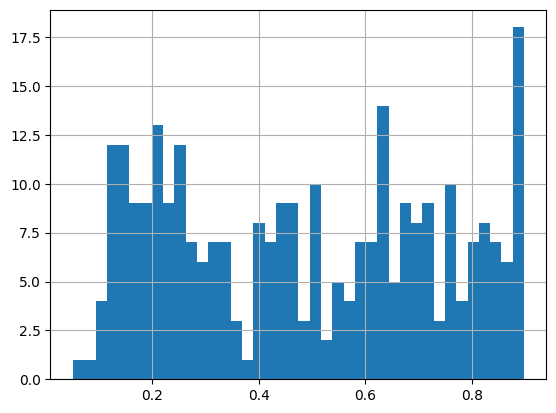

In [68]:
solo_rif_variants.true_frs.hist(bins=40)

And we can do the same thing for the other minor mutations; difference is we need to ignore any null calls, any non minor calls and we can also threshold based on `COV` to avoid very low coverage (can tweak this value to see what effect it has)

In [69]:
solo_other_variants = solo_other_mutations[['mutation']].join(variants, how='inner')
solo_other_variants = solo_other_variants[(~solo_other_variants.is_null) & (solo_other_variants.is_minor) & (solo_other_variants.COV>5)]
solo_other_variants[:3]

mutation  \
uniqueid                                           gene      gene_position             
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0           R225G:6   
                                                             227.0           R227G:6   
                                                             248.0          T248T:15   

                                                                                 variant  \
uniqueid                                           gene      gene_position                 
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0           839123a>g:6   
                                                             227.0           839129c>g:6   
                                                             248.0          839194a>g:15   

                                                                            codon_idx  \
uniqueid                                           gene      gene_position              
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                0.0   
                                                             227.0                0.0   
                                                             248.0                2.0   

                                                                            nucleotide_index  \
uniqueid                                           gene      gene_position                     
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                    839123   
                                                             227.0                    839129   
                                                             248.0                    839194   

                                                                            indel_length  \
uniqueid                                           gene      gene_position                 
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                     0   
                                                             227.0                     0   
                                                             248.0                     0   

                                                                           indel_nucleotides  \
uniqueid                                           gene      gene_position                     
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0                       NaN   
                                                             227.0                       NaN   
                                                             248.0                       NaN   

                                                                                                                 vcf_evidence  \
uniqueid                                           gene      gene_position                                                      
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0          {"GT_CONF_PERCENTILE": 0.02, "COV": [0, 6], "D...   
                                                             227.0          {"GT": [1, 1], "FRS": 1.0, "GT_CONF_PERCENTILE...   
                                                             248.0          {"GT_CONF": 115.47, "DP": 15, "ALLELE_DP": [0,...   

                                                                            vcf_idx  \
uniqueid                                           gene      gene_position            
site.00.subj.1473471.lab.H140800280.iso.1.v0.12... PE_PGRS10 225.0              1.0   
                                                             227.0              1.0   
                                                             248.0              1.0   

                                                                            is_minor  \
uniqueid                                           gene      gene_position             
site.00.subj.1473471.lab.H140800280.iso.1.v0.12

From this we can count the number of minor variants per sample using a `groupby`.

In [70]:
solo_other_variants.reset_index(inplace=True)
solo_other_variants_count = solo_other_variants[['uniqueid','gene_position']].groupby('uniqueid').count()
solo_other_variants_count.rename(columns={'gene_position':'minor_count'}, inplace=True)
solo_other_variants_count

,minor_count
uniqueid,
site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample,140
site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample,97
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample,78
site.00.subj.NETHERLANDS_NLA009702465.lab.NLA009702465.iso.1.v0.12.4.per_sample,117
site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.per_sample,1214
...,...
site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per_sample,1514
site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per_sample,1422
site.28.subj.2133.lab.R28017.iso.1.v0.12.4.per_sample,1384


Now we have everything we need; we just need to join both tables (remember this is explicitly just for the 291 samples which only have one RIF RAV)

In [71]:
df = solo_rif_variants.join(solo_other_variants_count)
df

,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,vcf_evidence,vcf_idx,is_minor,read_fraction,is_null,DP,FRS,COV,true_frs,minor_count
uniqueid,,,,,,,,,,,,,,,,,,
site.00.subj.1473471.lab.H140800280.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,"{""ALLELE_DP"": [42, 75], ""FRS"": 0.641, ""GT_CONF...",1.0,True,75.0,False,75.0,0.6410,117.0,0.641026,140
site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.per_sample,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,"{""DP"": 32, ""GT_CONF"": 124.78, ""GT"": [0, 0], ""A...",1.0,True,12.0,False,32.0,0.7273,44.0,0.272727,97
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1.v0.12.4.per_sample,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,"{""GT"": [0, 0], ""FRS"": 0.871, ""GT_CONF"": 430.96...",1.0,True,12.0,False,81.0,0.8710,93.0,0.129032,78
site.00.subj.NETHERLANDS_NLA009702465.lab.NLA009702465.iso.1.v0.12.4.per_sample,rpoB,445.0,H445D:11,761139c>g:11,0.0,761139,0,NaN,"{""COV"": [23, 11], ""DP"": 23, ""GT"": [0, 0], ""GT_...",1.0,True,11.0,False,23.0,0.6765,34.0,0.323529,117
site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:10,761155c>t:10,1.0,761155,0,NaN,"{""GT"": [0, 0], ""COV"": [69, 10], ""FRS"": 0.8734,...",1.0,True,10.0,False,69.0,0.8734,79.0,0.126582,1214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per_sample,rpoB,450.0,S450L:82,761155c>t:82,1.0,761155,0,NaN,"{""COV"": [57, 82], ""GT"": [1, 1], ""ALLELE_DP"": [...",1.0,True,82.0,False,82.0,0.5899,139.0,0.589928,1514
site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per_sample,rpoB,435.0,D435Y:28,761109g>t:28,0.0,761109,0,NaN,"{""FRS"": 0.7971, ""GT_CONF_PERCENTILE"": 12.66, ""...",1.0,True,28.0,False,110.0,0.7971,138.0,0.202899,1422
site.28.subj.2133.lab.R28017.iso.1.v0.12.4.per_sample,rpoB,435.0,D435Y:5,761109g>t:5,0.0,761109,0,NaN,"{""DP"": 32, ""GT_CONF"": 170.23, ""GT"": [0, 0], ""C...",1.0,True,5.0,False,32.0,0.8649,37.0,0.135135,1384


We could look at the scatter of FRS against the number of minors

(0.0, 5000.0)

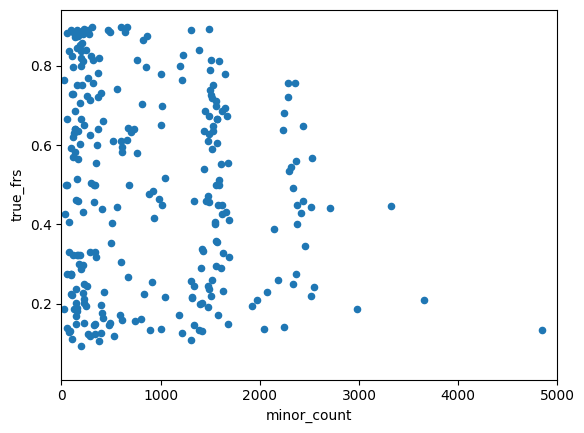

In [72]:
axes = df.plot.scatter(y='true_frs', x='minor_count')
axes.set_xlim([0,5000])

There is clearly some samples with very large numbers of minors; let's restrict the x-axis a bit

(0.0, 3000.0)

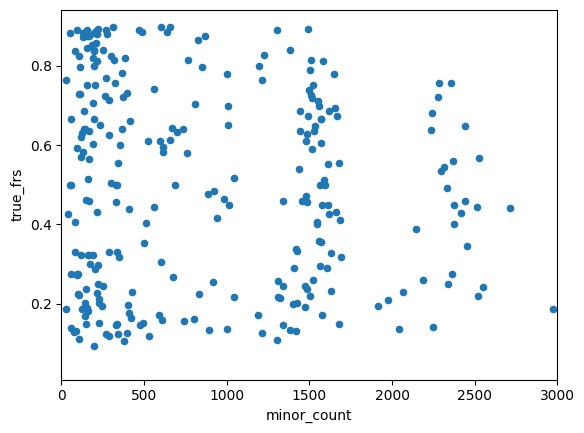

In [73]:
axes = df.plot.scatter(y='true_frs', x='minor_count')
axes.set_xlim([0,3000])

Perhaps the clearest way is to plot a bar chart with something like ">2000 minor variants" as an option e.g. via

In [74]:
def make_bins(row):
    if row.minor_count>2000:
        return 2000
    else:
        return 100*int(row.minor_count/100)

df['minor_bin'] = df.apply(make_bins, axis=1)
df.minor_bin.value_counts().sort_index()

minor_bin
0       20
100     47
200     28
300     21
400     11
500      7
600     11
700      5
800      8
900      5
1000     6
1100     2
1200     3
1300    10
1400    20
1500    26
1600    15
1900     2
2000    45
Name: count, dtype: int64

In [75]:
def correct_uid(row):
    return row.uniqueid.split('.v0.12.4.per_sample')[0]

df.reset_index(inplace=True)
df['UNIQUEID'] = df.apply(correct_uid, axis=1)
df.set_index('UNIQUEID', inplace=True)
df[:3]

,uniqueid,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,vcf_evidence,vcf_idx,is_minor,read_fraction,is_null,DP,FRS,COV,true_frs,minor_count,minor_bin
UNIQUEID,,,,,,,,,,,,,,,,,,,,
site.00.subj.1473471.lab.H140800280.iso.1,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,"{""ALLELE_DP"": [42, 75], ""FRS"": 0.641, ""GT_CONF...",1.0,True,75.0,False,75.0,0.6410,117.0,0.641026,140,100
site.00.subj.ES_FE21.lab.FE21.iso.1,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,"{""DP"": 32, ""GT_CONF"": 124.78, ""GT"": [0, 0], ""A...",1.0,True,12.0,False,32.0,0.7273,44.0,0.272727,97,0
site.00.subj.NETHERLANDS_NLA000301359.lab.NLA000301359.iso.1,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,"{""GT"": [0, 0], ""FRS"": 0.871, ""GT_CONF"": 430.96...",1.0,True,12.0,False,81.0,0.8710,93.0,0.129032,78,0


Let's get the ENA accession number of the samples in this plot from the cryptic ENA lookup table. We can then use this to pull the relevant samples from ENA and process them using mykrobe.

In [76]:
ENA_LOOKUP = pd.read_csv('/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/cryptic-tables-v2.1.2/ENA_LOOKUP.csv.gz')
ENA_LOOKUP.set_index('UNIQUEID', inplace=True)
ENA_LOOKUP[:3]

df2 = df.join(ENA_LOOKUP[['run_accession', 'fastq_ftp']], how='left')
df2 = df2[~df2.index.duplicated(keep=False)]
df2.to_csv('mykrobe_data/minor_rif_variants.csv')

In [77]:
df = pd.read_csv('mykrobe_data/minor_rif_variants.csv')
df.set_index('run_accession', inplace=True)
df[:3]

,UNIQUEID,uniqueid,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,...,is_minor,read_fraction,is_null,DP,FRS,COV,true_frs,minor_count,minor_bin,fastq_ftp
run_accession,,,,,,,,,,,,,,,,,,,,,
ERR2516785,site.00.subj.1473471.lab.H140800280.iso.1,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,...,True,75.0,False,75.0,0.6410,117.0,0.641026,140,100,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/005/ERR251...
ERR2516111,site.00.subj.ES_FE21.lab.FE21.iso.1,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,...,True,12.0,False,32.0,0.7273,44.0,0.272727,97,0,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/001/ERR251...
ERR2516629,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,...,True,12.0,False,81.0,0.8710,93.0,0.129032,78,0,ftp.sra.ebi.ac.uk/vol1/fastq/ERR251/009/ERR251...


In [78]:
mykrobe = pd.read_csv('mykrobe_data/mykrobe_results.csv')
mykrobe.set_index('ena_run_accession', inplace=True)
mykrobe[:3]

,lineage_count,lineage_1,lineage_2,lineage_3,lineage_4,mixture_type
ena_run_accession,,,,,,
ERR4800035,1,lineage3,NaN,NaN,NaN,single
ERR4798238,2,lineage3,lineage4.3.3,NaN,NaN,major
ERR4813926,1,lineage4.1.2.1,NaN,NaN,NaN,single


In [79]:
df = df.join(mykrobe)

In [80]:
df[(df.mixture_type=='major') & (df.minor_bin >= 2000 )].lineage_2.value_counts()

lineage_2
lineage2.2.7      9
lineage4.3.3      3
lineage2.2        2
lineage4.1.2.1    2
lineage5          1
lineage4.4.1.1    1
lineage4          1
lineage4.1.1      1
lineage3          1
lineage3.1.2      1
lineage2.2.3      1
lineage2.2.5      1
Name: count, dtype: int64

In [81]:
df[(df.mixture_type=='major')].minor_bin.value_counts()

minor_bin
2000    24
1500    23
1400    12
1600    11
1300     4
1200     2
1100     1
1900     1
800      1
Name: count, dtype: int64

In [82]:
pd.crosstab(df.minor_bin, df.mixture_type)

mixture_type,complex,major,minor,single
minor_bin,,,,
0,0,0,0,19
100,0,0,0,40
200,0,0,0,24
300,0,0,5,15
400,0,0,2,9
500,0,0,2,5
600,0,0,1,10
700,0,0,2,3
800,0,1,4,3


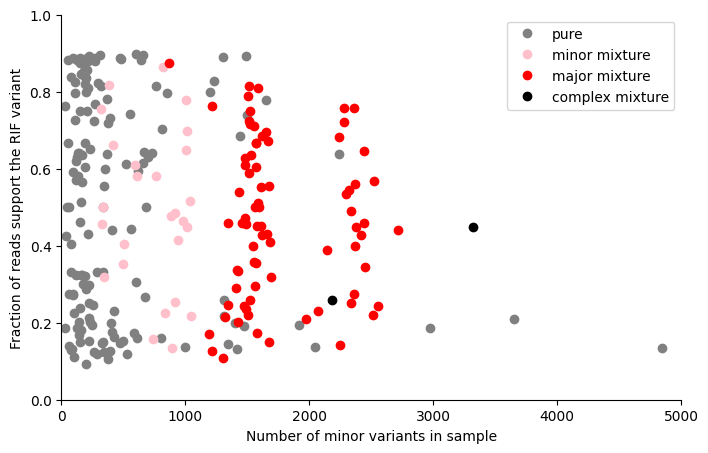

In [83]:
fig = plt.figure(figsize=(8, 5))
axes = fig.gca()

df2 = df[df.mixture_type=='single']
axes.plot(df2.minor_count, df2.true_frs, 'o', color='grey', label='pure')

df2 = df[df.mixture_type=='minor']
axes.plot(df2.minor_count, df2.true_frs, 'o', color='pink', label='minor mixture')

df2 = df[df.mixture_type=='major']
axes.plot(df2.minor_count, df2.true_frs, 'o', color='red', label='major mixture')

df2 = df[df.mixture_type=='complex']
axes.plot(df2.minor_count, df2.true_frs, 'o', color='black', label='complex mixture')

axes.legend(loc='upper right')
axes.set_xlim(0, 5000)
axes.set_ylim(0, 1)
axes.set_xlabel('Number of minor variants in sample')
axes.set_ylabel('Fraction of reads support the RIF variant')
axes.spines[["right", "top"]].set_visible(False)

fig.savefig('figures/fig-minor-rif-variants.pdf', bbox_inches='tight', transparent=True)

NameError: name 'df' is not defined

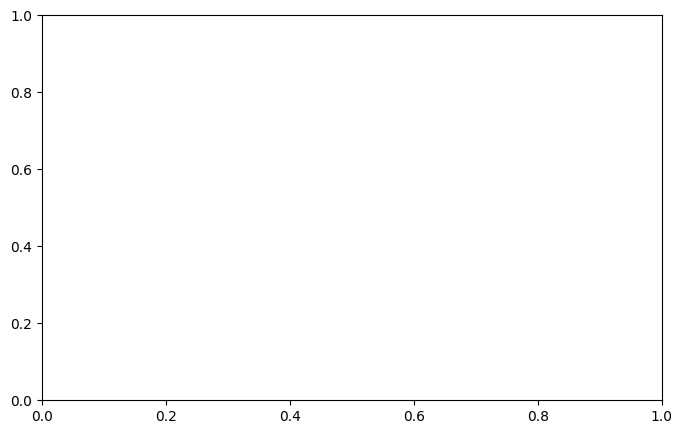

In [11]:
#plot the same data as a histogram plot, with a different color for each mixture type
fig = plt.figure(figsize=(8, 5))
axes = fig.gca()

df2 = df[df.mixture_type=='single']
axes.hist(df2.minor_count, bins=900, color='grey', label='pure', alpha=0.5)

df2 = df[df.mixture_type=='minor']
axes.hist(df2.minor_count, bins=4, color='pink', label='sublineage mixture', alpha=0.5)

df2 = df[df.mixture_type=='major']
axes.hist(df2.minor_count, bins=80, color='red', label='lineage mixture', alpha=0.5)

df2 = df[df.mixture_type=='complex']
axes.hist(df2.minor_count, bins=60, color='black', label='multiple lineage mixture', alpha=0.5)

axes.legend(loc='upper right')
axes.set_xlim(0, 3750)
axes.set_ylim(0, 60)
axes.set_xlabel('Number of minor variants in sample')
axes.set_ylabel('Number of samples')
axes.spines[["right", "top"]].set_visible(False)

fig.savefig('figures/fig-minor-rif-variants-bar.pdf', bbox_inches='tight', transparent=True)

In [75]:
df.lineage_2.value_counts()
df['lineage_1_main'] = df.lineage_1.apply(lambda x: x.split('.')[0] if isinstance(x, str) and '.' in x else x)
df['lineage_2_main'] = df.lineage_2.apply(lambda x: x.split('.')[0] if isinstance(x, str) and '.' in x else x)
df['lineage_mix'] = df.apply(
    lambda x: f'{x.lineage_1_main}+{x.lineage_2_main}' if pd.notna(x.lineage_1_main) and pd.notna(x.lineage_2_main) and x.lineage_1_main != x.lineage_2_main 
    else None,
    axis=1
)
# df['lineage_mix'] = df.apply(lambda x: f'{x.lineage_1_main}+{x.lineage_2_main}', axis=1)
df.mixture_type

run_accession
ERR2516785     single
ERR2516111     single
ERR2516629     single
ERR2516477     single
ERR13259958     major
                ...  
ERR9121135     single
ERR13285190     major
ERR9119906      major
ERR9119099     single
NaN               NaN
Name: mixture_type, Length: 274, dtype: object

Look at mix of lineages in major mixed samples

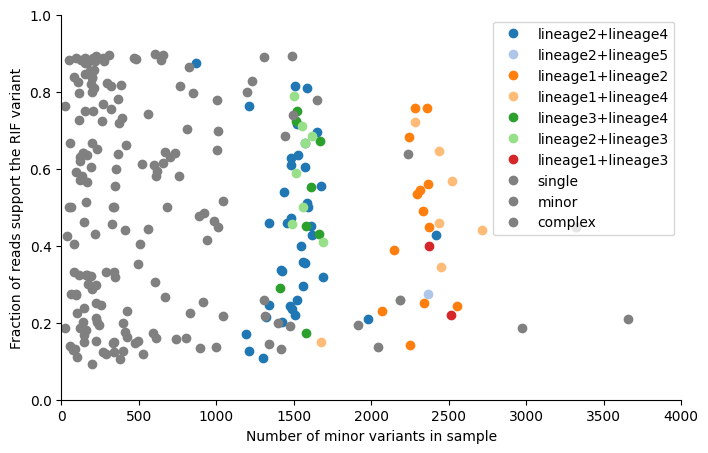

In [93]:
#colour the scatterplot according to lineage mix
fig = plt.figure(figsize=(8, 5))
axes = fig.gca()

# Set up a color palette with enough unique colors for each lineage and mixture type
unique_lineages = df.lineage_mix.dropna().unique()
palette = sns.color_palette("tab20", len(unique_lineages) + 3)  # Adding 3 for the mixture types

for i, lineage in enumerate(unique_lineages):
    df2 = df[df.lineage_mix==lineage]
    axes.plot(df2.minor_count, df2.true_frs, 'o', label=lineage, color=palette[i])

# Plot the mixture types using the remaining colors from the palette
mixture_colors = {'single': 'grey', 'minor': 'grey', 'complex': 'grey'}  # Define custom colors for clarity
for i, (mixture_type, color) in enumerate(mixture_colors.items(), start=len(unique_lineages)):
    df2 = df[df.mixture_type == mixture_type]
    axes.plot(df2.minor_count, df2.true_frs, 'o', color=color, label=mixture_type)

axes.legend(loc='upper right')
axes.set_xlim(0, 4000)
axes.set_ylim(0, 1)
axes.set_xlabel('Number of minor variants in sample')

axes.set_ylabel('Fraction of reads support the RIF variant')
axes.spines[["right", "top"]].set_visible(False)

fig.savefig('figures/fig-minor-rif-variants-lineage.pdf', bbox_inches='tight', transparent=True)

Try using a boxplot to capture median of the two clusters we see, similar to how it was done by Gagneux et al

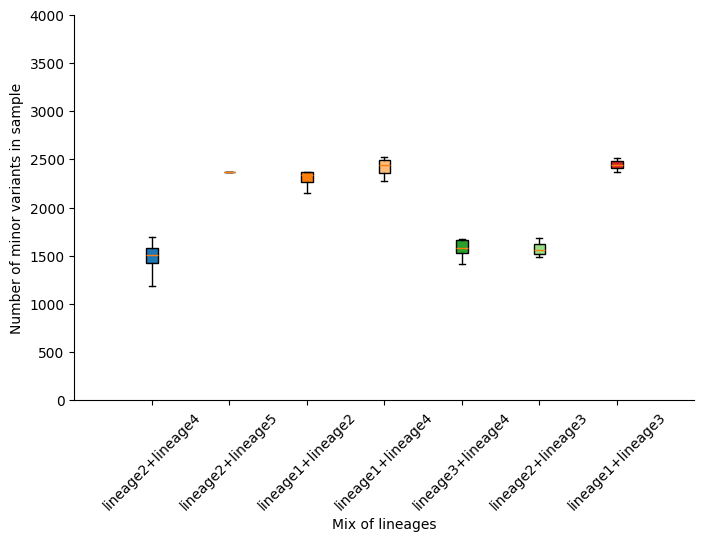

In [79]:
fig = plt.figure(figsize=(8, 5))
axes = fig.gca()

# Set up a color palette with enough unique colors for each lineage and mixture type
unique_lineages = df.lineage_mix.dropna().unique()
palette = sns.color_palette("tab20", len(unique_lineages) + 3)  # Adding 3 for the mixture types

for i, lineage in enumerate(unique_lineages):
    df2 = df[df.lineage_mix==lineage]
    axes.boxplot(df2.minor_count, positions=[i], showfliers=False, patch_artist=True, boxprops=dict(facecolor=palette[i]))

axes.set_xticks(range(len(unique_lineages)))
axes.set_xticklabels(list(unique_lineages), rotation=45)
axes.set_xlim(-1, len(unique_lineages))
axes.set_ylim(0, 4000)
axes.set_xlabel('Mix of lineages')
axes.set_ylabel('Number of minor variants in sample')
axes.spines[["right", "top"]].set_visible(False)

fig.savefig('figures/fig-minor-rif-variants-lineage-box.pdf', bbox_inches='tight', transparent=True)

Investigate which cities/ countries samples with mixed populations come from...

In [80]:
locations = pd.read_pickle('data/DST_SAMPLES.pkl.gz')
locations

,COUNTRY_CODE,SITEID,MYKROBE_LINEAGE_NAME_1,MYKROBE_LINEAGE_NAME_2,SPECIES,BELONGS_GPI1,BELONGS_GPI2,NUMBER_DST,N_DATASETS,HAS_LID2015_DST,HAS_NEJM2018_DST,HAS_MUMBAI2018_DST,HAS_WHO2019_DST,HAS_PHE2019_DST,HAS_CRYPTIC1_DST,HAS_CLIRES2020_DST,HAS_SEQTREAT2020_DST,HAS_CRYPTIC2_DST,HAS_NICD2022_DST,HAS_CLIRES2023_DST
UNIQUEID,,,,,,,,,,,,,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,GBR,00,Lineage 2,lineage2.2.10,NaN,False,False,8,1,False,True,False,False,False,False,False,False,False,False,False
site.00.subj.1000595.lab.H123460044.iso.1,GBR,00,Lineage 2,lineage2.2.9,NaN,False,False,9,1,False,True,False,False,False,False,False,False,False,False,False
site.00.subj.1004213.lab.H111060034.iso.1,GBR,00,Lineage 2,lineage2.2.6,NaN,False,False,8,1,False,True,False,False,False,False,False,False,False,False,False
site.00.subj.1004213.lab.H112000008.iso.1,GBR,00,Lineage 2,lineage2.2.6,NaN,False,False,9,1,False,True,False,False,False,False,False,False,False,False,False
site.00.subj.1004213.lab.H113100007.iso.1,GBR,00,Lineage 2,lineage2.2.6,NaN,False,False,9,1,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
site.ENA.subj.SAMN08892584.lab.1.iso.1,PAK,EN,Lineage 4,lineage4.5,NaN,False,False,9,1,False,False,False,True,False,False,False,False,False,False,False
site.ENA.subj.SAMN08892585.lab.1.iso.1,PAK,EN,Lineage 4,lineage4.2.2,NaN,False,False,9,1,False,False,False,True,False,False,False,False,False,False,False
site.ENA.subj.SAMN08892586.lab.1.iso.1,PAK,EN,Lineage 3,lineage3,NaN,False,False,11,1,False,False,False,True,False,False,False,False,False,False,False


In [81]:
df['location'] = df.UNIQUEID.map(locations.COUNTRY_CODE)
df

,UNIQUEID,uniqueid,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,...,lineage_count,lineage_1,lineage_2,lineage_3,lineage_4,mixture_type,lineage_1_main,lineage_2_main,lineage_mix,location
run_accession,,,,,,,,,,,,,,,,,,,,,
ERR2516785,site.00.subj.1473471.lab.H140800280.iso.1,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,...,1.0,lineage2.2,NaN,NaN,NaN,single,lineage2,NaN,None,GBR
ERR2516111,site.00.subj.ES_FE21.lab.FE21.iso.1,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,...,1.0,lineage4.1.2.1,NaN,NaN,NaN,single,lineage4,NaN,None,ESP
ERR2516629,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,...,1.0,lineage4.4.1.1,NaN,NaN,NaN,single,lineage4,NaN,None,NLD
ERR2516477,site.00.subj.NETHERLANDS_NLA009702465.lab.NLA0...,site.00.subj.NETHERLANDS_NLA009702465.lab.NLA0...,rpoB,445.0,H445D:11,761139c>g:11,0.0,761139,0,NaN,...,1.0,lineage4.1.2.1,NaN,NaN,NaN,single,lineage4,NaN,None,NLD
ERR13259958,site.01.subj.DR0182.lab.DR0182.iso.1,site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.p...,rpoB,450.0,S450L:10,761155c>t:10,1.0,761155,0,NaN,...,2.0,lineage2.2.9,lineage4.10,NaN,NaN,major,lineage2,lineage4,lineage2+lineage4,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR9121135,site.26.subj.16.lab.G102.iso.1,site.26.subj.16.lab.G102.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:16,761155c>t:16,1.0,761155,0,NaN,...,1.0,lineage2.2.10,NaN,NaN,NaN,single,lineage2,NaN,None,ESP
ERR13285190,site.28.subj.1007.lab.R12077.iso.2,site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per...,rpoB,450.0,S450L:82,761155c>t:82,1.0,761155,0,NaN,...,2.0,lineage2.2.1,lineage3,NaN,NaN,major,lineage2,lineage3,lineage2+lineage3,ZAF
ERR9119906,site.28.subj.1371.lab.R12076.iso.1,site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per...,rpoB,435.0,D435Y:28,761109g>t:28,0.0,761109,0,NaN,...,2.0,lineage2.2,lineage4.10,NaN,NaN,major,lineage2,lineage4,lineage2+lineage4,ZAF


Mixes of more than one lineage are not intuitive, but make sense to happen in big melting pot cities like Mumbai. The plot here is by country

['GBR' 'ESP' 'NLD' 'USA' 'CHN' 'DEU' 'TKM' 'CMR' 'AZE' 'MDA' 'IND' 'PER'
 'ITA' 'PAK' 'VNM' 'BTN' 'ZAF' 'BRA' 'CAN' 'IRL']


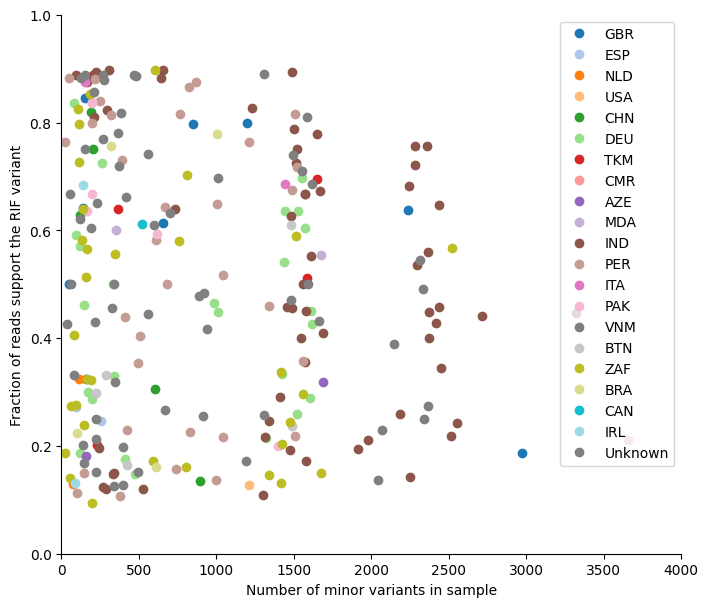

In [119]:
#colour the scatterplot according to lineage mix
fig = plt.figure(figsize=(8, 7))
axes = fig.gca()

# Set up a color palette with enough unique colors for each lineage and mixture type
unique_countries = df.location.dropna().unique()
print(unique_countries)
palette = sns.color_palette("tab20", len(unique_countries))  # Adding 3 for the mixture types

for i, country in enumerate(unique_countries):
    df2 = df[df.location==country]
    axes.plot(df2.minor_count, df2.true_frs, 'o', label=country, color=palette[i])

    # Plot NaN-associated samples
df_nan = df[df.location.isna()]
if not df_nan.empty:
    axes.plot(df_nan.minor_count, df_nan.true_frs, 'o', label='Unknown', color='gray')

axes.legend(loc='upper right')
axes.set_xlim(0, 4000)
axes.set_ylim(0, 1)
axes.set_xlabel('Number of minor variants in sample')

axes.set_ylabel('Fraction of reads support the RIF variant')
axes.spines[["right", "top"]].set_visible(False)

fig.savefig('figures/fig-minor-rif-variants-country.pdf', bbox_inches='tight', transparent=True)

In [83]:
#check if there is an association between mixture_type, site and lineage_mix
# pd.crosstab(df.site, df.lineage_mix)

pd.crosstab(df.location, df.mixture_type)

mixture_type,complex,major,minor,single
location,,,,
AZE,0,1,0,1
BRA,0,0,2,2
BTN,0,2,0,3
CAN,0,0,0,1
CHN,0,0,1,4
CMR,0,0,0,1
DEU,0,8,3,11
ESP,0,0,0,2
GBR,0,0,0,10


In [111]:
#check if location IND is associated with a mixture type using a fisher test of IND vs other locations and combining complex and major into one category
from scipy.stats import fisher_exact
contingency = pd.crosstab(df.location, df.mixture_type)
contingency['complex_major'] = contingency['complex'] + contingency['major']
contingency.drop(columns=['complex', 'major'], inplace=True)
contingency['single_minor'] = contingency['single'] + contingency['minor']
contingency.drop(columns=['single', 'minor'], inplace=True)
contingency

# IND vs other locations
ind = contingency.loc['IND']
other = contingency.drop('IND')
ind_vs_other = pd.DataFrame({
    'IND': ind,
    'Other': other.sum()
})
print(ind_vs_other)

odds_ratio, p_value = fisher_exact(ind_vs_other)
odds_ratio, p_value

               IND  Other
mixture_type             
complex_major   40     34
single_minor    29    115


(np.float64(4.665314401622718), np.float64(6.137755256329799e-07))

In [114]:
#perform this check for all countries in the dataset
significant_countries = []

for country in df.location.dropna().unique():
    contingency = pd.crosstab(df.location, df.mixture_type)
    contingency['complex_major'] = contingency['complex'] + contingency['major']
    contingency.drop(columns=['complex', 'major'], inplace=True)
    contingency['single_minor'] = contingency['single'] + contingency['minor']
    contingency.drop(columns=['single', 'minor'], inplace=True)
    test_country = contingency.loc[country]
    other = contingency.drop(country)
    test_country_vs_other = pd.DataFrame({
        country: test_country,
        'Other': other.sum()
    })
    odds_ratio, p_value = fisher_exact(test_country_vs_other)
    print(f'{country}: OR={odds_ratio:.2f}, p={p_value:.3f}')
    if p_value < 0.05/len(df.location.dropna().unique()):
        significant_countries.append(country)

significant_countries

GBR: OR=0.00, p=0.017
ESP: OR=0.00, p=0.549
NLD: OR=0.00, p=0.549
USA: OR=inf, p=0.339
CHN: OR=0.00, p=0.169
DEU: OR=1.13, p=0.815
TKM: OR=1.31, p=1.000
CMR: OR=0.00, p=1.000
AZE: OR=1.96, p=1.000
MDA: OR=1.96, p=1.000
IND: OR=4.67, p=0.000
PER: OR=0.50, p=0.157
ITA: OR=0.00, p=0.549
PAK: OR=0.00, p=0.098
VNM: OR=1.23, p=0.766
BTN: OR=1.31, p=1.000
ZAF: OR=0.47, p=0.112
BRA: OR=0.00, p=0.302
CAN: OR=0.00, p=1.000
IRL: OR=0.00, p=1.000


['IND']

Check in which bins we find the compensatory mutations

In [84]:
df['minor_CM'] = df.UNIQUEID.isin(res_minor_CM_minor_uniqueids)
df

,UNIQUEID,uniqueid,gene,gene_position,mutation,variant,codon_idx,nucleotide_index,indel_length,indel_nucleotides,...,lineage_1,lineage_2,lineage_3,lineage_4,mixture_type,lineage_1_main,lineage_2_main,lineage_mix,location,minor_CM
run_accession,,,,,,,,,,,,,,,,,,,,,
ERR2516785,site.00.subj.1473471.lab.H140800280.iso.1,site.00.subj.1473471.lab.H140800280.iso.1.v0.1...,rpoB,450.0,S450L:75,761155c>t:75,1.0,761155,0,NaN,...,lineage2.2,NaN,NaN,NaN,single,lineage2,NaN,None,GBR,False
ERR2516111,site.00.subj.ES_FE21.lab.FE21.iso.1,site.00.subj.ES_FE21.lab.FE21.iso.1.v0.12.4.pe...,rpoB,445.0,H445D:12,761139c>g:12,0.0,761139,0,NaN,...,lineage4.1.2.1,NaN,NaN,NaN,single,lineage4,NaN,None,ESP,False
ERR2516629,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,site.00.subj.NETHERLANDS_NLA000301359.lab.NLA0...,rpoB,445.0,H445Y:12,761139c>t:12,0.0,761139,0,NaN,...,lineage4.4.1.1,NaN,NaN,NaN,single,lineage4,NaN,None,NLD,False
ERR2516477,site.00.subj.NETHERLANDS_NLA009702465.lab.NLA0...,site.00.subj.NETHERLANDS_NLA009702465.lab.NLA0...,rpoB,445.0,H445D:11,761139c>g:11,0.0,761139,0,NaN,...,lineage4.1.2.1,NaN,NaN,NaN,single,lineage4,NaN,None,NLD,False
ERR13259958,site.01.subj.DR0182.lab.DR0182.iso.1,site.01.subj.DR0182.lab.DR0182.iso.1.v0.12.4.p...,rpoB,450.0,S450L:10,761155c>t:10,1.0,761155,0,NaN,...,lineage2.2.9,lineage4.10,NaN,NaN,major,lineage2,lineage4,lineage2+lineage4,USA,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR9121135,site.26.subj.16.lab.G102.iso.1,site.26.subj.16.lab.G102.iso.1.v0.12.4.per_sample,rpoB,450.0,S450L:16,761155c>t:16,1.0,761155,0,NaN,...,lineage2.2.10,NaN,NaN,NaN,single,lineage2,NaN,None,ESP,False
ERR13285190,site.28.subj.1007.lab.R12077.iso.2,site.28.subj.1007.lab.R12077.iso.2.v0.12.4.per...,rpoB,450.0,S450L:82,761155c>t:82,1.0,761155,0,NaN,...,lineage2.2.1,lineage3,NaN,NaN,major,lineage2,lineage3,lineage2+lineage3,ZAF,False
ERR9119906,site.28.subj.1371.lab.R12076.iso.1,site.28.subj.1371.lab.R12076.iso.1.v0.12.4.per...,rpoB,435.0,D435Y:28,761109g>t:28,0.0,761109,0,NaN,...,lineage2.2,lineage4.10,NaN,NaN,major,lineage2,lineage4,lineage2+lineage4,ZAF,False


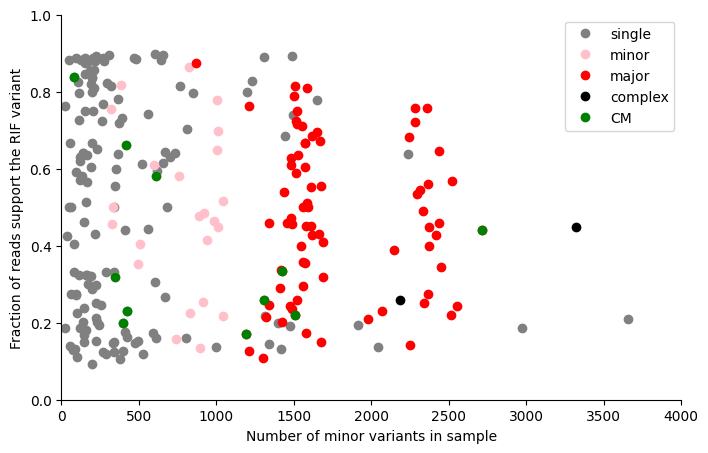

In [120]:
#colour the scatterplot according to lineage mix
fig = plt.figure(figsize=(8, 5))
axes = fig.gca()

# Plot the mixture types using the remaining colors from the palette
mixture_colors = {'single': 'grey', 'minor': 'pink', 'major': 'red', 'complex': 'black'}  # Define custom colors for clarity
for i, (mixture_type, color) in enumerate(mixture_colors.items(), start=len(unique_lineages)):
    df2 = df[df.mixture_type == mixture_type]
    axes.plot(df2.minor_count, df2.true_frs, 'o', color=color, label=mixture_type)

CM_colours = {True: 'green'}
for i, (CM, color) in enumerate(CM_colours.items(), start=len(unique_lineages)):
    df2 = df[df.minor_CM == CM]
    axes.plot(df2.minor_count, df2.true_frs, 'o', color=color, label='CM' if CM else 'non-CM')

axes.legend(loc='upper right')
axes.set_xlim(0, 4000)
axes.set_ylim(0, 1)
axes.set_xlabel('Number of minor variants in sample')

axes.set_ylabel('Fraction of reads support the RIF variant')
axes.spines[["right", "top"]].set_visible(False)

fig.savefig('figures/fig-minor-rif-variants-CMs.pdf', bbox_inches='tight', transparent=True)

In [97]:
pd.crosstab(df.minor_CM, df.mixture_type)

mixture_type,complex,major,minor,single
minor_CM,,,,
False,3,75,23,156
True,0,4,3,4


In [103]:
#perform fishers test to check if distribution of CMs is favored towards mixed infections: yse categories minor_CM and mixtures_type
from scipy.stats import fisher_exact
contingency = pd.crosstab(df.minor_CM, df.mixture_type)
contingency

#combine the complex, major and minor categories
contingency['mix'] = contingency['complex'] + contingency['major'] + contingency['minor']
contingency.drop(['complex', 'major', 'minor'], axis=1, inplace=True)
contingency

oddsratio, pvalue = fisher_exact(contingency)
oddsratio, pvalue


(np.float64(2.702970297029703), np.float64(0.12490097418247924))

Check for other types of resistance in resistant minor population samples (keeping in mind that it's not straightforward to decide if minor popualtion produces reads or major population...)

In [69]:
import gzip
input_file = "/Users/viktoriabrunner/Documents/Studium/PhD/DPhil/cryptic-tables-v2.1.2/MUTATIONS.pkl.gz"
with gzip.open(input_file, "rb") as f:
        mutations_all = pd.read_pickle(f)
mutations_all.reset_index(inplace=True)

#add resistance and compensatory mutation flags to mutations table: need to check for minor allele before concatenating GENE_MUTATION 
# use resistance catalogue of WHO instead?
mutations_all['GENE_MUTATION'] = np.where(
    mutations_all['IS_MINOR_ALLELE'],  # Condition: if IS_MINOR_ALLELE is True
    mutations_all['GENE'].astype(str) + '_' + mutations_all['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations_all['GENE'].astype(str) + '_' + mutations_all['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)
    
mutations_all['RESISTANT_MUTATION'] = mutations_all['GENE_MUTATION'].isin(resistance_mutations)
mutations_all['COMPENSATORY_MUTATION'] = mutations_all['GENE_MUTATION'].isin(compensatory_mutations)

#get the maximum FRS value for RIF in samples with a minor allele RIF resistance mutation
mutations_all['RIF_FRS_max'] = mutations_all[(mutations_all.UNIQUEID.isin(res_minor_uniqueids)) & (mutations_all.IS_MINOR_ALLELE == True) & (mutations_all.RESISTANT_MUTATION == True)].groupby('UNIQUEID')['FRS'].transform('max')
#if theres a value in the RIF_FRS_max column, expand that value to all rows of the same UNIQUEID
mutations_all['RIF_FRS_max'] = mutations_all.groupby('UNIQUEID')['RIF_FRS_max'].transform('max')

#filter out only those samples, where the INH FRS is correlated with the RIF FRS

mutations_all['FRS_range'] = mutations_all['FRS'].between(mutations_all['RIF_FRS_max']-0.2, mutations_all['RIF_FRS_max']+0.2)
mutations_all

KeyboardInterrupt: 

In [67]:
#load known resistance mutations from EFFECTS table
effects = pd.read_pickle('data/EFFECTS.pkl.gz')
effects.reset_index(inplace = True)
effects['GENE_MUTATION'] = effects['GENE'].astype(str) + '_' + effects['MUTATION']
effects = effects[(effects.DRUG=='INH') & (effects.PREDICTION=='R') 
                  & (~effects.MUTATION.str[-1].isin(['O','X']))]

INH_resistance_mutations = effects.GENE_MUTATION.unique()
len(INH_resistance_mutations)

146

In [68]:
mutations_all['INH_RESISTANT_MUTATION'] = mutations_all['GENE_MUTATION'].isin(INH_resistance_mutations)
mutations_all

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,...,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION,RIF_FRS_max,FRS_range,INH_RESISTANT_MUTATION
0,site.01.subj.DR0682.lab.DR0682.iso.1,fadD34,S16W,tcg,tgg,NaN,NaN,16.0,True,NaN,...,1.0,False,None,NaN,fadD34_S16W,False,False,NaN,False,False
1,site.01.subj.DR0682.lab.DR0682.iso.1,fadD34,T26S,act,tct,NaN,NaN,26.0,True,NaN,...,1.0,False,None,NaN,fadD34_T26S,False,False,NaN,False,False
2,site.01.subj.DR0682.lab.DR0682.iso.1,Rv1231c,L60L,ctg,ctc,NaN,NaN,60.0,True,NaN,...,1.0,False,None,NaN,Rv1231c_L60L,False,False,NaN,False,False
3,site.01.subj.DR0682.lab.DR0682.iso.1,nth,P2R,ccc,cgc,NaN,NaN,2.0,True,NaN,...,1.0,False,None,NaN,nth_P2R,False,False,NaN,False,False
4,site.01.subj.DR0682.lab.DR0682.iso.1,Rv0465c,C106R,tgc,cgc,NaN,NaN,106.0,True,NaN,...,1.0,False,None,NaN,Rv0465c_C106R,False,False,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57566027,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv0881,G115R,ggc,cgc,NaN,NaN,115.0,True,NaN,...,1.0,False,None,NaN,Rv0881_G115R,False,False,NaN,False,False
57566028,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv0890c,P866A,ccc,gcc,NaN,NaN,866.0,True,NaN,...,1.0,False,None,NaN,Rv0890c_P866A,False,False,NaN,False,False
57566029,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv1514c,S159S,tca,tcg,NaN,NaN,159.0,True,NaN,...,1.0,False,None,NaN,Rv1514c_S159S,False,False,NaN,False,False
57566030,site.07.subj.FD_127_2228.lab.13_0613254.iso.1,Rv3113,Y81D,tat,gat,NaN,NaN,81.0,True,NaN,...,1.0,False,None,NaN,Rv3113_Y81D,False,False,NaN,False,False


In [69]:
INH_res_minor_allele_mutations = mutations_all[(mutations_all.UNIQUEID.isin(res_minor_uniqueids) & (mutations_all.IS_MINOR_ALLELE == True)) & (mutations_all.INH_RESISTANT_MUTATION == True) & (mutations_all.FRS_range)]
INH_res_minor_allele_mutations.IS_MINOR_ALLELE.value_counts()

IS_MINOR_ALLELE
True    203
Name: count, dtype: int64

In [71]:
len(INH_res_minor_allele_mutations.UNIQUEID.unique())/len(res_minor_uniqueids)

0.4018264840182648

0.9329552101519692


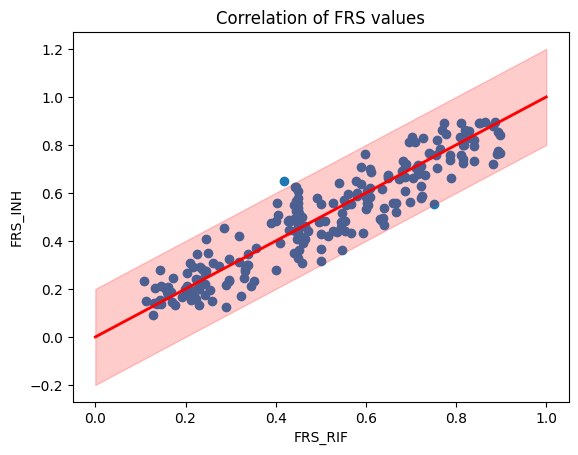

In [72]:
RIF_minor_INH_minor_uniqueids = INH_res_minor_allele_mutations.UNIQUEID.unique()

RIF_resistance = mutations_all[(mutations_all.RESISTANT_MUTATION == True) & (mutations_all.UNIQUEID.isin(RIF_minor_INH_minor_uniqueids))& (mutations_all.FRS_range)]
INH_resistance = mutations_all[(mutations_all.UNIQUEID.isin(RIF_minor_INH_minor_uniqueids)) & (mutations_all.INH_RESISTANT_MUTATION == True)& (mutations_all.FRS_range)]

#join dfs resistance and compensation based on UNIQUEID
df_joined = pd.merge(RIF_resistance[['UNIQUEID','MINOR_MUTATION','FRS']], INH_resistance[['UNIQUEID','MINOR_MUTATION','FRS']], on = 'UNIQUEID', how = 'inner')
df_joined.rename(columns = {'FRS_x':'FRS_RIF','FRS_y':'FRS_INH','MINOR_MUTATION_x':'MINOR_MUTATION_RIF','MINOR_MUTATION_y':'MINOR_MUTATION_INH'}, inplace = True)
df_joined

#compare the FRX_x and FRS_y columns to see if the FRS values are roughly the samed
df_joined['FRS_RIF'] = df_joined['FRS_RIF'].astype(float)
df_joined['FRS_INH'] = df_joined['FRS_INH'].astype(float)

print(df_joined['FRS_RIF'].corr(df_joined['FRS_INH']))

#plot the FRS values for the samples with a minor allele and a compensatory mutation
plt.scatter(df_joined['FRS_RIF'], df_joined['FRS_INH']) 
#add a line through (1,1) to (0,0) to indicate a perfect correlation
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_RIF')
plt.ylabel('FRS_INH')
plt.title('Correlation of FRS values')

# add a filled field range of +-0.1 around the perfect correlation line
plt.fill_between([0, 1], [0, 1], [0.2, 1.2], color='red', alpha=0.2)
plt.fill_between([0, 1], [0, 1], [-0.2, 0.8], color='red', alpha=0.2)

plt.show()

#extract only those INH mutations, whose FRS is correlated with RIF FRS
# INH_res_minor_allele_mutations = INH_res_minor_allele_mutations[INH_res_minor_allele_mutations.UNIQUEID.isin(df_joined.UNIQUEID)]

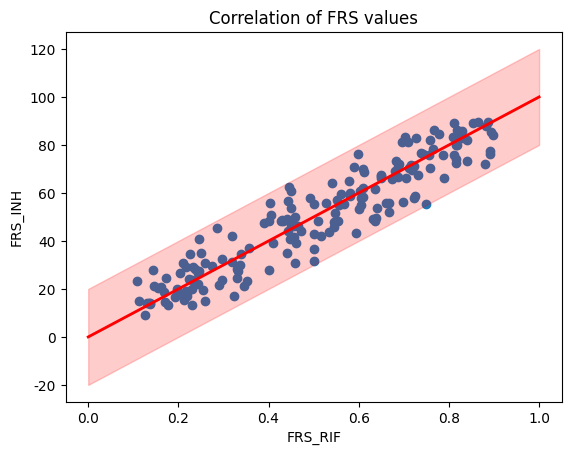

In [73]:
#Check how Pearson correlation changes if we remove minor resistant mutations from the same sample and only keep the higher FRS value
df_joined_max = df_joined.groupby('UNIQUEID').agg({'FRS_RIF':'max', 'FRS_INH':'max'}).reset_index()
correlation_max, p_value_max = pearsonr(df_joined_max['FRS_RIF'], df_joined_max['FRS_INH'])
correlation_max, p_value_max

#plot correlation of FRS values for samples with a minor allele and a compensatory mutation, keeping only the higher FRS value
plt.scatter(df_joined_max['FRS_RIF'], df_joined_max['FRS_INH'])
plt.plot([0, 1], [0, 1], color='red', lw=2)
plt.xlabel('FRS_RIF')
plt.ylabel('FRS_INH')
plt.title('Correlation of FRS values')

# Set axes to display values as percentages without the percent sign
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y * 100)))

#save figure in high resolution
plt.savefig('figures/FRS_correlation_INH.png', dpi=300)

# add a filled field range of +-0.1 around the perfect correlation line
plt.fill_between([0, 1], [0, 1], [0.2, 1.2], color='red', alpha=0.2)
plt.fill_between([0, 1], [0, 1], [-0.2, 0.8], color='red', alpha=0.2)

plt.show()

In [75]:
len(INH_res_minor_allele_mutations.UNIQUEID.unique())/len(res_minor_uniqueids)

0.4018264840182648

In [77]:
mutations_all[(mutations_all['RESISTANT_MUTATION']==False) & (mutations_all['IS_MINOR_ALLELE']) & (mutations_all['UNIQUEID'].isin(res_minor_uniqueids)) & (mutations_all['FRS_range'])]

,UNIQUEID,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,...,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,RESISTANT_MUTATION,COMPENSATORY_MUTATION,RIF_FRS_max,FRS_range,INH_RESISTANT_MUTATION
150044,site.01.subj.DR0182.lab.DR0182.iso.1,gid,A205Z,gca,zzz,NaN,NaN,205.0,True,NaN,...,1.0,True,A205A,0.151,gid_A205A,False,False,0.127,True,False
150045,site.01.subj.DR0182.lab.DR0182.iso.1,gid,E92Z,gaa,zzz,NaN,NaN,92.0,True,NaN,...,1.0,True,E92D,0.173,gid_E92D,False,False,0.127,True,False
150046,site.01.subj.DR0182.lab.DR0182.iso.1,rpsL,K43Z,aag,zzz,NaN,NaN,43.0,True,NaN,...,1.0,True,K43R,0.168,rpsL_K43R,False,False,0.127,True,False
150047,site.01.subj.DR0182.lab.DR0182.iso.1,embB,M306Z,atg,zzz,NaN,NaN,306.0,True,NaN,...,1.0,True,M306V,0.140,embB_M306V,False,False,0.127,True,False
150048,site.01.subj.DR0182.lab.DR0182.iso.1,rpoB,A1075Z,gct,zzz,NaN,NaN,1075.0,True,NaN,...,1.0,True,A1075A,0.165,rpoB_A1075A,False,False,0.127,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57505033,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,gyrA,V352Z,gtg,zzz,NaN,NaN,352.0,True,NaN,...,1.0,True,V352V,0.254,gyrA_V352V,False,False,0.364,True,False
57505034,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,gyrA,V366Z,gtt,zzz,NaN,NaN,366.0,True,NaN,...,1.0,True,V366V,0.226,gyrA_V366V,False,False,0.364,True,False
57505035,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,gyrA,V395Z,gtt,zzz,NaN,NaN,395.0,True,NaN,...,1.0,True,V395V,0.243,gyrA_V395V,False,False,0.364,True,False
57505036,site.07.subj.B2BA5DAF-6370-4E99-B3E9-782C61686...,gyrA,V404Z,gtc,zzz,NaN,NaN,404.0,True,NaN,...,1.0,True,V404V,0.205,gyrA_V404V,False,False,0.364,True,False
